# HI, HeI and CaII population

- 2020.06.10   k.i. 
- 2020.07.16   k.i., u.k.    population plot
- 2020.07.20   k.i.  add Src & tau_1D in both CloudModel.py    
- 2020.07.24   k.u.,k.i.  Transition_heatmap
- 2020.07.29   k.i.,k.u.  rename to HHeCa.jpynb,   cal_SE_with_Pg_Te_()

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import numpy as np

#%matplotlib inline
#%matplotlib qt
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%load_ext autoreload
%autoreload 2

from spectra_src.ImportAll import *
import warnings
warnings.simplefilter('ignore', UserWarning)
warnings.simplefilter('ignore', DeprecationWarning)

C:\Users\lelou\AppData\Local\Temp\ipykernel_39584\875321342.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
from spectra_src.Struct import Atom, Atmosphere, Radiation
from spectra_src.Atomic import Collision, SEsolver, ContinuumOpacity, BasicP
from spectra_src.Util.HelpUtil import help_
from spectra_src.Visual import Plotting  #, Grotrian
from spectra_src.Atomic import LTELib
from spectra_src.Function.SEquil import SELib
from spectra_src.Atomic import Hydrogen
from spectra_src.Util.AtomUtils.AtomInfo import level_info, extract_lprof, each_prof, line_list
from spectra_src import Constants as Cst
from spectra_src.Function.SlabModel import CloudModel


## Create atomic model for H, He, Ca

In [3]:
# Atomic model
import os

conf_path = os.path.join( CFG._ROOT_DIR, "data/conf/H.conf" )
atom_H, wMesh_H, path_dict_H = Atom.init_Atom_(conf_path , is_hydrogen=True)
conf_path = os.path.join( CFG._ROOT_DIR, "data/conf/He.conf" )
atom_He, wMesh_He, path_dict_He = Atom.init_Atom_(conf_path , is_hydrogen=False)
#conf_path = os.path.join( CFG._ROOT_DIR, "data/conf/Ca_I-II-III.conf" )
conf_path = os.path.join( CFG._ROOT_DIR, "data/conf/Ca_II.conf" )
atom_Ca, wMesh_Ca, path_dict_ca = Atom.init_Atom_(conf_path , is_hydrogen=False)


## Make Solar spectrum array

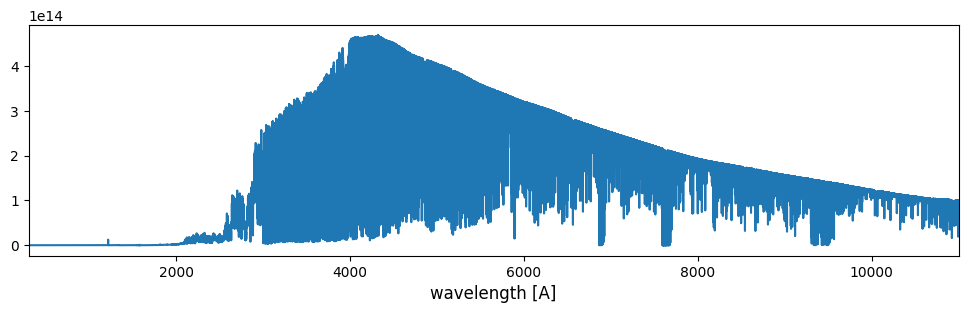

In [4]:
#  prepare solar radiation spectrum
import copy

atmos = Atmosphere.Atmosphere0D(Nh=1.E12, Ne=1.E11, Te=7.E3, Vd=0., Vt=5.E5)
solar_spec_H  = Radiation.init_Radiation_(atmos, wMesh_H)
solar_spec_He = Radiation.init_Radiation_(atmos, wMesh_He)
solar_spec_Ca = Radiation.init_Radiation_(atmos, wMesh_Ca)

wls = solar_spec_H.backRad[0,:]*1E8         
wls_air = BasicP.vacuum_to_air_(wls,'AA')   # wavelength in air of background solar spectrum [A]
Isolar = solar_spec_H.backRad[1,:].copy()   # background solar spectrum intensity    "    [erg/cm^3/s/str]

#  for photo-excitation, mean intensity gets half of the backgroud solar spectrum
solar_spec_H.backRad[1,:] *= 0.5            # solar spectrum mean intensity    "    [erg/cm^3/s/str]
solar_spec_H.PI_intensity[:,:] *= 0.5       # solar spectrum mean intensity    "    [erg/cm^3/s/str]
solar_spec_He.backRad[1,:] *= 0.5           # solar spectrum mean intensity    "    [erg/cm^3/s/str]
solar_spec_He.PI_intensity[:,:] *= 0.5      # solar spectrum mean intensity    "    [erg/cm^3/s/str]
solar_spec_Ca.backRad[1,:] *= 0.5           # solar spectrum mean intensity    "    [erg/cm^3/s/str]
solar_spec_Ca.PI_intensity[:,:] *= 0.5      # solar spectrum mean intensity    "    [erg/cm^3/s/str]

solar_spec_H0 = copy.deepcopy(solar_spec_H)
solar_spec_He0 = copy.deepcopy(solar_spec_He)
solar_spec_Ca0 = copy.deepcopy(solar_spec_Ca)


fig, ax = plt.subplots(1,1, figsize=(12,3), dpi=100)
ax.plot(wls_air, Isolar)
ax.set_xlim(300, 11000)
#ax.set_xlim(10820, 10840) ; ax.set_ylim(0,1.2e14)
#ax.set_yscale("log") ; ax.set_ylim(1e7,1e15)
ax.set_xlabel("wavelength [A]", fontsize=12)
plt.show()

## Calc. SE and line profiles for H, He, Ca for a [$T_e,n_H$]

In [5]:
def enhance_EUV(solar_spec,wMesh,ampl,wleuv=504.):  # Enhance EUV for He 1083nm
    
    # amp_euv = 10.  #  enhance EUV radiation for He 10830

    solar_spec2 = copy.deepcopy(solar_spec)
    wleuv *= 1e-8
    print("wleuv=",wleuv)

    ii = np.where(solar_spec2.backRad[0,:] < wleuv)[0]
    solar_spec2.backRad[1,ii] *= ampl
    ii = np.where(wMesh.Cont_mesh.reshape(-1) < wleuv)[0]
    solar_spec2.PI_intensity.reshape(-1)[ii] *= ampl
    
    return solar_spec2
    

In [18]:
# import CloudModel from spectra_src.Function.SlabModel

Te = 8000.
Nh = 1*1e11
Ne = 2e10
Vd = 0.
Vt = 5e5            #   cm/s
depth = 0.5E4 * 1.E5 #   km *1e5
ampl = 10   # EUV enhancement for He background

solar_spec_He = enhance_EUV(solar_spec_He0,wMesh_He,ampl)

slab = Atmosphere.Atmosphere0D(Nh=Nh, Ne=Ne, Te=Te, Vd=Vd, Vt=Vt, use_Tr=False)     # slab 
SE_H, Rate_H = SELib.cal_SE_with_Nh_Te_(atom_H, slab, wMesh_H, solar_spec_H, None)  #  level populations etc.
lH = CloudModel.SE_to_slab_0D_(atom_H, slab, SE_H, depth=depth)      # hydrogen lines intensity
SE_He, Rate_He = SELib.cal_SE_with_Nh_Te_(atom_He, slab, wMesh_He, solar_spec_He, SE_H.n_SE)  #  level populations etc.
lHe = CloudModel.SE_to_slab_0D_(atom_He, slab, SE_He, depth=depth)      # hydrogen lines intensity
SE_Ca, Rate_Ca = SELib.cal_SE_with_Nh_Te_(atom_Ca, slab, wMesh_Ca, solar_spec_Ca, SE_H.n_SE)  #  level populations etc.
lCa = CloudModel.SE_to_slab_0D_(atom_Ca, slab, SE_Ca, depth=depth)      # hydrogen lines intensity


wleuv= 5.04e-06


## Plot H, He, CaII emissions w/ a prominence spectrum

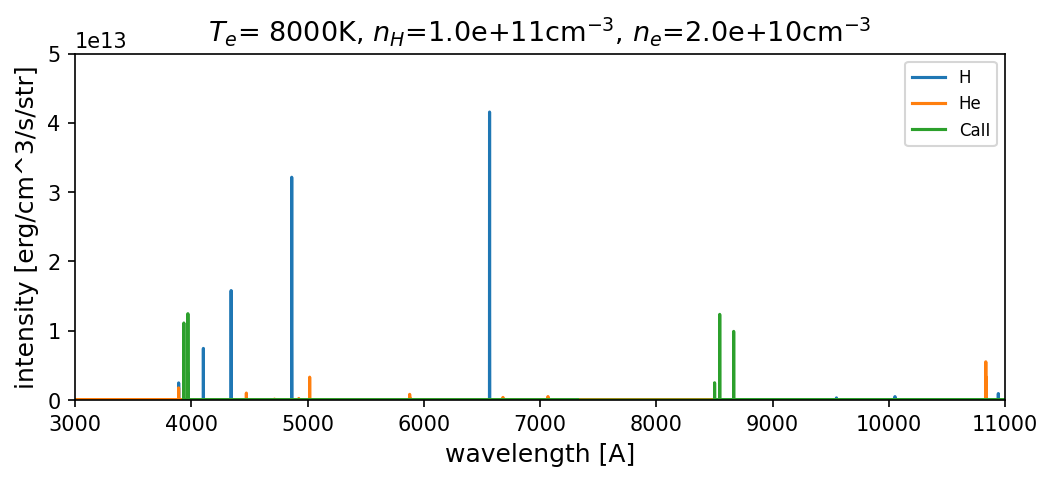

In [13]:
fig, ax = plt.subplots(1,1, figsize=(8,3), dpi=150)
ax.plot(lH.wl_1D*1e8,lH.prof_1D,label='H')
ax.plot(lHe.wl_1D*1e8,lHe.prof_1D,label='He')
ax.plot(lCa.wl_1D*1e8,lCa.prof_1D,label='CaII')
ax.set_ylim(1e9,1E14)
#ax.set_xlim(300, 12000)
#ax.set_xscale("log")
ax.set_xlim(3000, 11000)
#ax.set_yscale("log")
ax.set_ylim(0, 5e13)
ax.set_xlabel("wavelength [A]", fontsize=12)
ax.set_ylabel("intensity [erg/cm^3/s/str]", fontsize=12)
plt.title("$T_e$={0:5.0f}K, $n_H$={1:5.1e}cm$^{{-3}}$, $n_e$={2:5.1e}cm$^{{-3}}$".format(Te, Nh, Ne),fontsize=13)
ax.legend(fontsize=8,ncol=1)
plt.show()

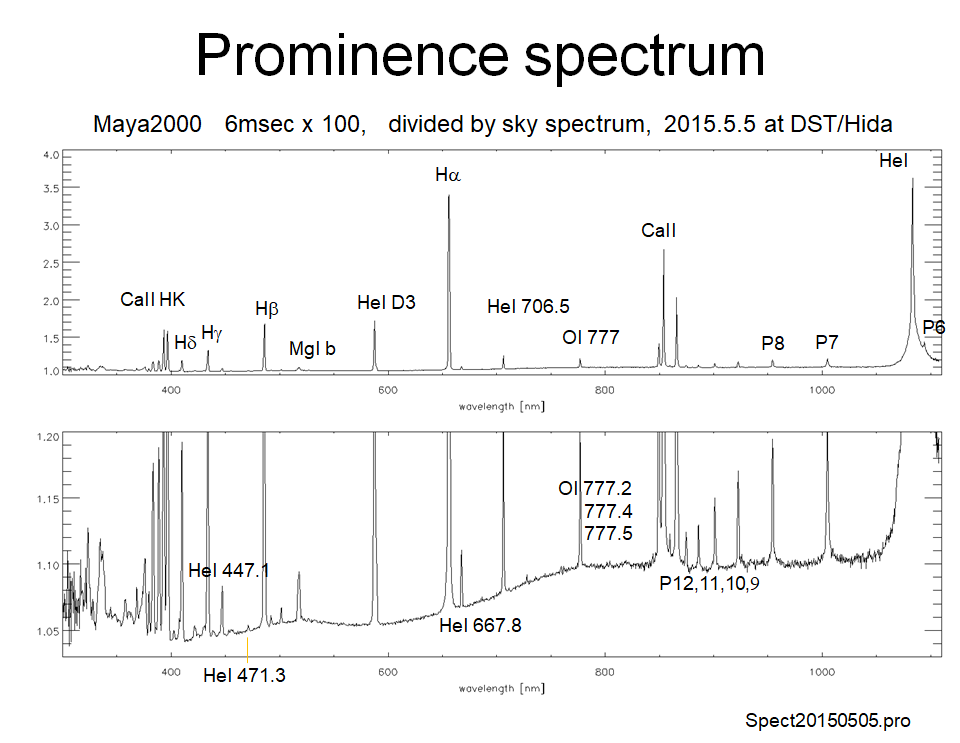

# Extract lines of interest 
## plot intensity profile from a slab with a continuum background

### cloud model: $\qquad$    $I_{out} = I_{c} e^{-\tau} + S (1-e^{-\tau})$

In [14]:
#-------------------------------------------------------------
def extract_line(l, wl, Ic=0.):
#-------------------------------------------------------------
# extract line profile in a wl interval from l-structure
# wl[:]  -- in A 
# Ic  -- background intensity

    nw = wl.size
    profe = np.zeros(nw)
    tau = np.zeros(nw)

    w0 = l.w0 *1e8
    jj = np.where((w0 > min(wl)) & (w0 < max(wl)))[0]

    for j in jj:
        idx1 = l.Line_mesh_idxs[j,0] 
        idx2 = l.Line_mesh_idxs[j,1]
        tau1 = np.interp(wl, l.wl_1D[idx1:idx2]*1e8, l.tau_1D[idx1:idx2])
        prof1 = l.Src[j] * (1.-np.exp(-tau1))
        #print('Ic, Src=',Ic,l.Src[j])
        tau += tau1
        profe += prof1
        
    prof = Ic*np.exp(-tau) + profe
    
    ldat = {
        "intens": prof,
        "tau": tau,
        "src": max(l.Src[jj]),
    }
    
    return ldat


In [15]:
def wlarr(wl00,vmax,dv):
# return wl[:] around wl00 in A,  vmax, dv  in km/s

    dw = dv/Cst.c_*wl00*1e5
    wmin = wl00 - dw*vmax/dv
    wmax = wl00 + dw*vmax/dv
    nw = 2*int(vmax/dv) +1
    #nw = int((wmax-wmin)/dw) + 1
    wl = np.linspace(wmin,wmax,nw)
    return wl


dict_keys(['elem', 'wl0', 'wl', 'wl_air', 'Isolar', 'Ic'])
dict_keys(['elem', 'wl0', 'wl', 'wl_air', 'Isolar', 'Ic'])
dict_keys(['elem', 'wl0', 'wl', 'wl_air', 'Isolar', 'Ic'])


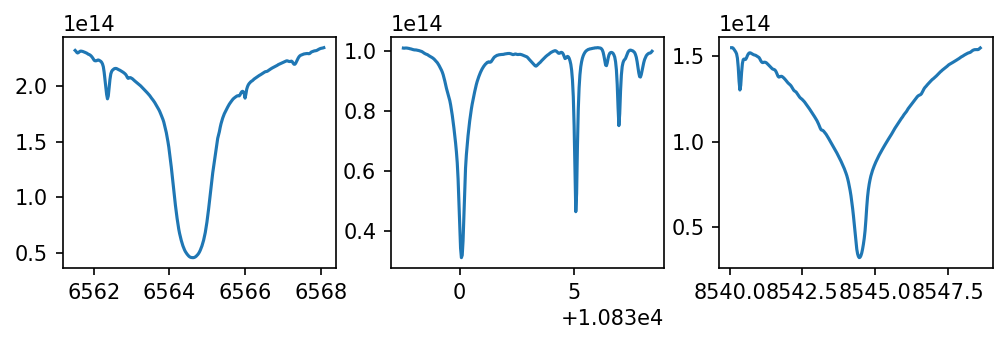

In [19]:
### define lines of interest ###

vmax = 150. ; dv = 1.  # km/s

ls = [
    {'elem': 'H',  'wl0': 6563.},
    {'elem': 'He', 'wl0': 10830.},
    {'elem':'Ca',  'wl0': 8542.}
    #{'elem':'Ca',  'wl0': 3934.}
]

nl = len(ls)
for i in range(nl):
    wl_air = wlarr( ls[i]['wl0'], vmax, dv )  # w-array in air centered by the line
    wl = BasicP.air_to_vacuum_(wl_air,'AA') # w-array in vacuum
    Isol = np.interp(wl, wls, Isolar)        # Solar spectrum of the line
    Ic = np.max(Isol)                         # continuum intensity
    ls[i].update({'wl': wl, 'wl_air': wl_air, 'Isolar': Isol, 'Ic': Ic})
    print(ls[i].keys())

### plot a line profile in solar spectrum ###
fig, axs = plt.subplots(1,nl, figsize=(8,2), dpi=150)
for i in range(nl):
    axs[i].plot(ls[i]['wl'],ls[i]['Isolar'])
    ax.set_ylim(0,max(ls[i]["Isolar"])*1.2)


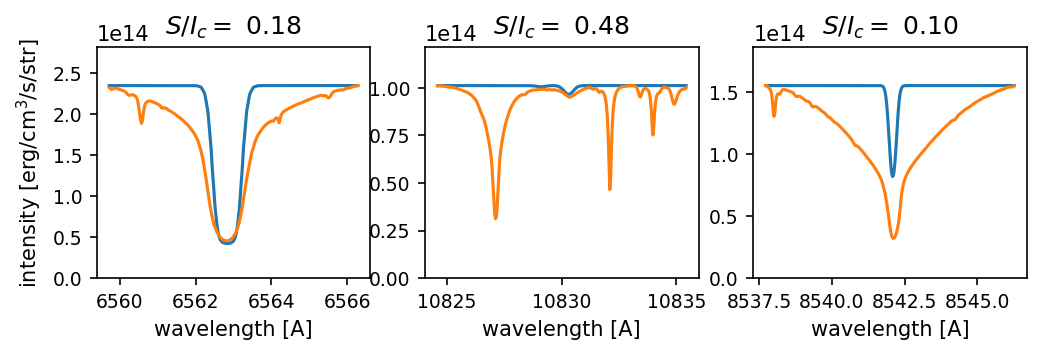

In [20]:
##  plot line profiles with background continuum

fig, axs = plt.subplots(1,nl, figsize=(8,2), dpi=150)

for i in range(nl):
    if ls[i]['elem'] == 'H':
        l_elm = lH
    elif ls[i]['elem'] == 'He':
        l_elm = lHe
    elif ls[i]['elem'] =='Ca':
        l_elm = lCa
    l1 = extract_line(l_elm, ls[i]['wl'], Ic=ls[i]['Ic'])   #  ['intens', 'tau', 'src']
    ls[i].update(l1)
    ax = axs[i]
    ax.plot(ls[i]['wl_air'], ls[i]['intens'])
    ax.plot(ls[i]['wl_air'], ls[i]['Isolar'])
    ax.set_xlabel("wavelength [A]", fontsize=10)
    ax.tick_params(axis ='x', labelsize =9)
    ax.tick_params(axis ='y', labelsize =9)
    if i == 0:
        ax.set_ylabel("intensity [erg/cm$^3$/s/str]", fontsize=10)
    ax.set_ylim(0,max(ls[i]["intens"])*1.2)
    ax.set_title(r"$S/I_c=$"+f"{ls[i]['src']/ls[i]['Ic']:5.2F}")


In [21]:
help_(lCa)
np.empty([5,2])

------------------------------------------------------------------------------------------
name                       type                                 value/len/shape
------------------------------------------------------------------------------------------
CloudModel_Container
|- w0                      ndarray                              s: (10,)
|- tau_max                 ndarray                              s: (10,)
|- Ibar                    ndarray                              s: (10,)
|- Src                     ndarray                              s: (10,)
|- tau_1D                  ndarray                              s: (860,)
|- prof_1D                 ndarray                              s: (860,)
|- wl_1D                   ndarray                              s: (860,)
|- Line_mesh_idxs          ndarray                              s: (10, 2)


array([[1.0e+12, 2.0e+12],
       [2.5e+12, 5.0e+12],
       [1.0e+13, 2.0e+13],
       [2.5e+13, 5.0e+13],
       [1.0e+14, 2.0e+14]])

## Display level population and transition rates

In [22]:
##  method to access to Level info.
atom = atom_Ca
print('level stage',atom.Level['stage'])
print('level energy',atom.Level['erg'])
print('config. term, j',atom._ctj_table.Level[3])     
int(atom._ctj_table.Level[3][1][0]) == 3          # level#=3, 1=term,  '3'

level stage [2 2 2 2 2 3]
level energy [0.00000000e+00 2.71153653e-12 2.72359131e-12 5.00415674e-12
 5.04843289e-12 1.90205906e-11]
config. term, j ('1s2.2s2.2p6.3s2.3p6.4p', '2P', '1/2')


False

## Display level population and transition rates

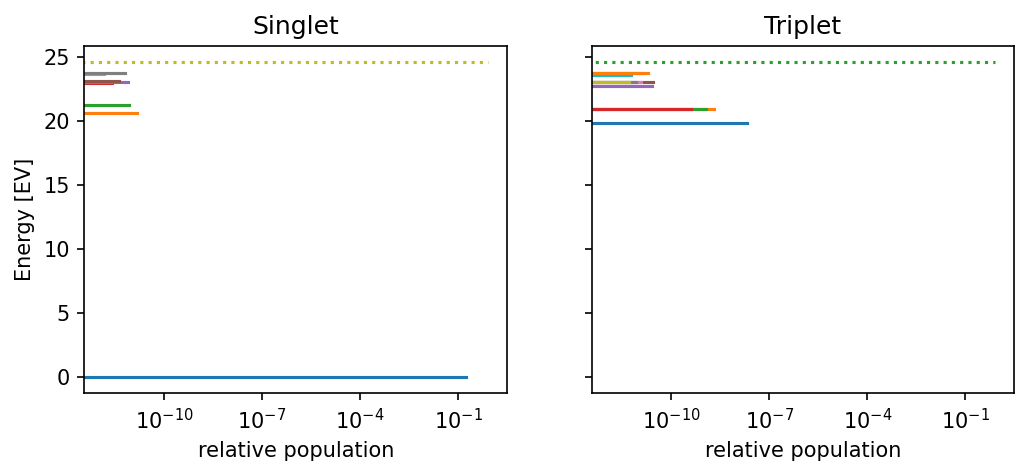

In [21]:
##  plot He level populations  ####################################################

atom = atom_He
SE = SE_He
mask = atom.Level['stage'] == 1           # select neutoral
ilevel_heii = np.where(atom.Level['stage'] == 2)[0][0]      # HeI ionization = groud state of HeII

level_erg = atom.Level['erg'][mask]
level_erg = np.append( level_erg, atom.Level['erg'][ilevel_heii] )
level_ev  = level_erg / Cst.eV2erg_
level_energy = level_ev

level_pop = SE.n_SE[mask]
level_pop = np.append( level_pop,  SE.n_SE[np.logical_not(mask)].sum())

fig, axs = plt.subplots(1,2, figsize=[8,3], dpi=150, sharey=True, sharex=True)

#axt = axs.twinx()
for i in range(level_erg.shape[0]):
    s2p1 = int(atom._ctj_table.Level[i][1][0])   #  1 - HeI singlet, 2 - HeII or 3 - HeI triplet
    if s2p1 == 1:
        axs[0].set_title('Singlet')
        axs[0].plot([0,level_pop[i]],level_energy[i]*np.ones(2))
    elif s2p1 == 3:
        axs[1].set_title('Triplet')
        axs[1].plot([0,level_pop[i]],level_energy[i]*np.ones(2))
    elif s2p1 == 2:
        axs[0].plot([0,level_pop[i]],level_energy[i]*np.ones(2),':')
        axs[1].plot([0,level_pop[i]],level_energy[i]*np.ones(2),':')        
    else:
        continue
    #print(i, level_pop[i])
    
for ax in axs:
    ax.set_xscale('log')
    ax.set_xlabel('relative population')
axs[0].set_ylabel('Energy [EV]')
#ax.plot(level_erg,level_pop,'o')
#ax.barh(level_erg,level_pop, align='center')
#level_erg
plt.show()

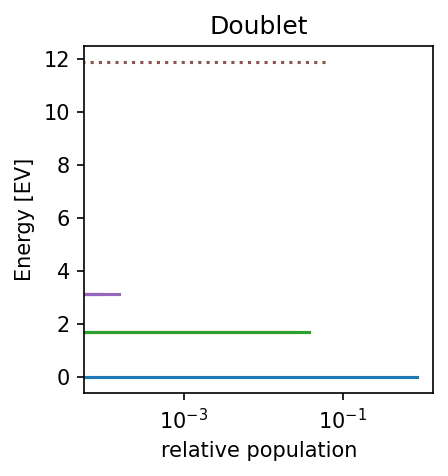

In [22]:
##  plot Ca level populations  ####################################################

atom = atom_Ca   
SE = SE_Ca
mask = atom.Level['stage'] == 2           # select neutoral
ilevel_caiii = np.where(atom.Level['stage'] == 3)[0][0]      # HeI ionization = groud state of HeII

level_erg = atom.Level['erg'][mask]
level_erg = np.append( level_erg, atom.Level['erg'][ilevel_caiii] )
level_ev  = level_erg / Cst.eV2erg_
level_energy = level_ev

level_pop = SE.n_SE[mask]
level_pop = np.append( level_pop,  SE.n_SE[np.logical_not(mask)].sum())

fig, ax = plt.subplots(1,1, figsize=[3,3], dpi=150, sharey=True, sharex=True)

#axt = axs.twinx()
for i in range(level_erg.shape[0]):
    s2p1 = int(atom._ctj_table.Level[i][1][0])   #  1 - HeI singlet, 2 - HeII or 3 - HeI triplet
    if s2p1 == 2:
        ax.set_title('Doublet')
        ax.plot([0,level_pop[i]],level_energy[i]*np.ones(2))
    elif s2p1 == 1:
        ax.plot([0,level_pop[i]],level_energy[i]*np.ones(2),':')
    else:
        continue
    #print(i, level_pop[i])
    
ax.set_xscale('log')
ax.set_xlabel('relative population')
ax.set_ylabel('Energy [EV]')
#ax.plot(level_erg,level_pop,'o')
#ax.barh(level_erg,level_pop, align='center')
#level_erg
plt.show()

In [23]:
#------------------------------------------------------------
def transition_heatmap(atom, SE_con, Rate_con, vmin=None, vmax=None, klevel_max=None,cmap='cool',title_prefix='',figsize=(10,6),level_order='energy'):

    #SE_con = SE_He
    #Rate_con = Rate_He
    numeric_error=1E-17
    if klevel_max is None: klevel_max = atom.nLevel
    #klevel_max = 21
    
    if level_order == 'multiplet':    # -- consider only HeI
        ctj_level = atom._ctj_table.Level
        idx_singlet = []
        idx_triplet = []
        idx_doublet = []    #  He ion 
        s2p1_list = []
        for i in range(klevel_max):
            #print(atom.Level['stage'][i])
            ctj = ctj_level[i]
            s2p1 = ctj[1][0]
            if s2p1 == '1':   # singlet
                idx_singlet.append(i)
            elif s2p1 == '3':
                idx_triplet.append(i)
            elif s2p1 == '2':
                idx_doublet.append(i)
            else:
                continue
        idx_sort = idx_singlet + idx_triplet + idx_doublet
        #icont = np.where( (atom.Level['stage']==2) * (atom.Level['isGround']==1) )[0][0]
        #print(f"idx of continuum is {icont}")
        #idx_sort.append(icont)
        n_SE = SE_con.n_SE[idx_sort]
        Rmat = Rate_con.Rmat[idx_sort,:][:,idx_sort]
        Cmat = Rate_con.Cmat[idx_sort,:][:,idx_sort]
        n_SE = SE_con.n_SE[idx_sort].reshape(1,-1)
        ctj_level = [ctj_level[i] for i in idx_sort]
        ctjs = [f"{ctj[1]} {ctj[2]}" for ctj in ctj_level[:klevel_max]]
    else:
        Rmat = Rate_con.Rmat[:klevel_max,:klevel_max]
        Cmat = Rate_con.Cmat[:klevel_max,:klevel_max]
        n_SE = SE_con.n_SE[:klevel_max].reshape(1,-1)
        ctjs = [f"{ctj[1]} {ctj[2]}" for ctj in atom._ctj_table.Level[:klevel_max]]

    tran_mat = {
        "Radiative" : Rmat * n_SE,
        "Collision" : Cmat * n_SE,
    }

    #if vmin is None: vmin = min( [mat.min() for mat in tran_mat.values()] )
    #if vmax is None: vmax = max( [mat.max() for mat in tran_mat.values()] )
    if vmin is None: vmin = 1e-6
    if vmax is None: vmax = 1e-2
    norm = LogNorm(vmin, vmax, clip=True)

    fig, axs = plt.subplots(1,2, figsize=figsize, dpi=100, sharey=True)
    
    for ax, name in zip( axs, ("Radiative", "Collision") ):
        im = ax.imshow( tran_mat[name] + numeric_error, origin="lower", cmap=cmap, norm=norm )
        if name == "Radiative" and title_prefix != '':
            ax.set_title(name+f" | {title_prefix}")
        else:
            ax.set_title(name)
        ax.set_xticks([i for i in range(klevel_max)])
        ax.set_xticklabels(ctjs, rotation=75, fontsize=8)
        ax.set_yticks([i for i in range(klevel_max)])
        ax.set_yticklabels(ctjs, rotation=0, fontsize=8)


    # colorbar
    cax = fig.add_axes([0.93, 0.2, 0.02, 0.6])
    fig.colorbar( im, cax=cax, orientation='vertical')

    plt.show()
    return None



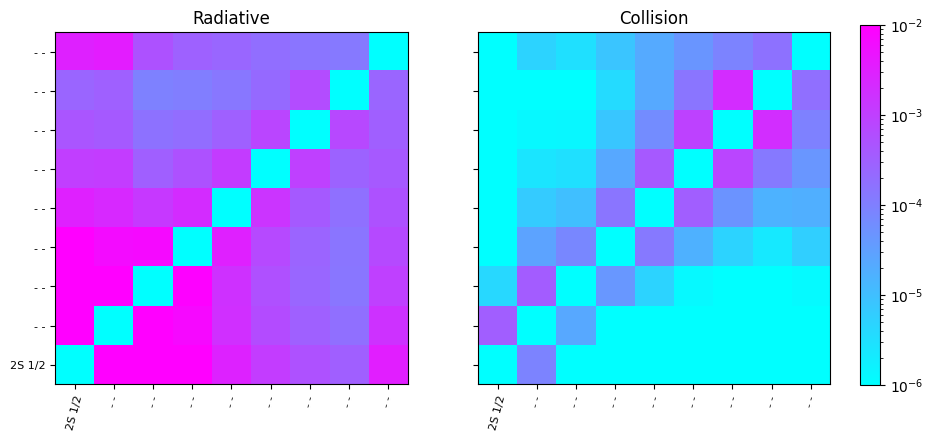

In [24]:
# Transition rale  H
transition_heatmap(atom_H, SE_H, Rate_H, vmin=1e-6, vmax=1e-2) #, klevel_max=21, level_order='multiplet')

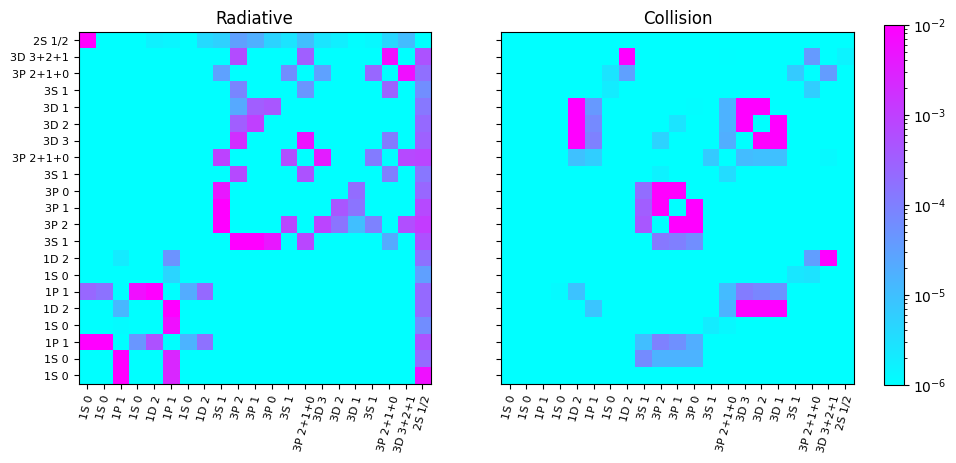

In [25]:
# Transition rale  He
transition_heatmap(atom_He, SE_He, Rate_He, vmin=1e-6, vmax=1e-2, klevel_max=21, level_order='multiplet')

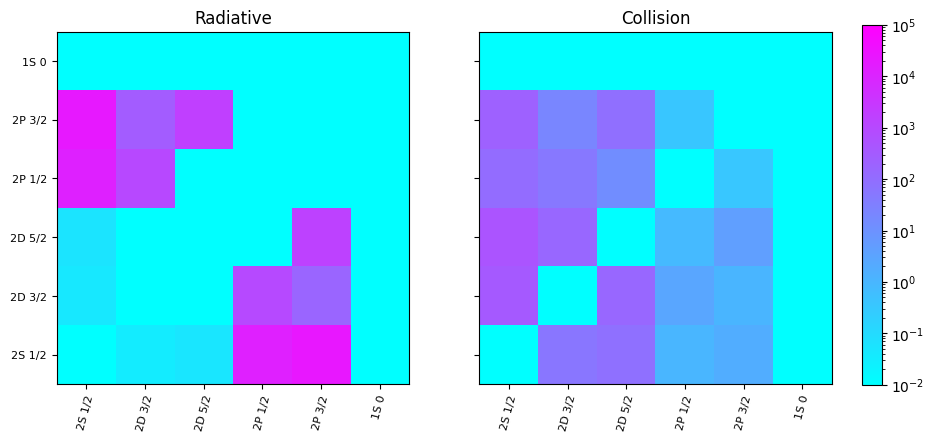

In [32]:
# Ca
#transition_heatmap(atom_Ca, SE_Ca, Rate_Ca,vmin=1e-2,vmax=1e5, klevel_max=31) #, level_order='multiplet')
transition_heatmap(atom_Ca, SE_Ca, Rate_Ca,vmin=1e-2,vmax=1e5)#, klevel_max=31) #, level_order='multiplet')
#help_(atom_Ca)

In [33]:
help_(atom_Ca)

------------------------------------------------------------------------------------------
name                       type                                 value/len/shape
------------------------------------------------------------------------------------------
Atom
|- Z                       int                                  v: 20
|- Mass                    float                                v: 40.08
|- Abun                    float                                v: 2.2908676527677747e-06
|- nLevel                  int                                  v: 6
|- nLine                   int                                  v: 10
|- nCont                   int                                  v: 5
|- nTran                   int                                  v: 15
|- nRL                     int                                  v: 5
|- Level                   struct array                         s: (6,)
  |-  erg                  float64                              s: (6,)
  |-  g  

## Calc. SE and line intensities of HI, HeI, CaII on [$T_e, n_H$] plane 

In [28]:
### result container (dict)including level population & iline intensity etc.
def r_container(atom, N_arr, Te_arr, wl_1D, Line_mesh_idxs):
    
    nN = len(N_arr)
    nTe = len(Te_arr)
    nw = len(wl_1D)
    r = {
        "N_arr" :   N_arr,                 # density array
        "Te_arr" :  Te_arr,                 # temperature array
        "pop_LTE" : np.empty((atom.nLevel, nN, nTe), dtype="float64"),  # LTE level population
        "pop_SE"  : np.empty((atom.nLevel, nN, nTe), dtype="float64"),  # SE level population
        "wl0" :    atom.Line['w0_AA'],                # line center wavelengths in A
        "Line_mesh_idxs": Line_mesh_idxs,
        "wl_1D":   wl_1D*1e8,       # 1D wavwlwngth in A
        "prof_3D": np.empty((nw, nN, nTe), dtype="float64"),
        "tau_3D":  np.empty((nw, nN, nTe), dtype="float64"),
        "src" :    np.empty((atom.nLine, nNh, nTe), dtype="float64"),
    }
    return r

def calc_popl(slab, depth, atom, wMesh, solar_spec, HnSE, r, j, k ):

    SE, Rate = SELib.cal_SE_with_Nh_Te_(atom, slab, wMesh, solar_spec, HnSE)  #  level populations etc.
    l = CloudModel.SE_to_slab_0D_(atom, slab, SE, depth=depth)      # hydrogen lines intensity
    r["pop_LTE"][:,j,k] = SE.n_LTE[:]
    r["pop_SE"][:,j,k] = SE.n_SE[:]
    r["prof_3D"][:,j,k] = l.prof_1D
    r["tau_3D"][:,j,k] = l.tau_1D
    r["src"][:,j,k] = l.Src
    n_SE = SE.n_SE

    return r

In [29]:
#***** define name of save files *****
savdir = 'E:\\tmp\\SE_result\\'
os.makedirs(savdir,exist_ok=True)
H_file = 'HI_NhTe.jbl'
He_file = 'HeI_NhTe.jbl'
#Ca_file = 'CaI_II_III_NhTe.jbl'
Ca_file = 'CaII_NhTe.jbl'


In [30]:
#from joblib import Parallel, delayed

#******  calculate populations in SE & LTS on (Te, Nh) ******

nTe = 51 ; Te_arr = np.linspace(2820, 39820, nTe)  # Te=8000
nNh = 51 ; Nh_arr = np.logspace(9, 14, nNh)
#Te_arr = np.array([5000.,8000,20000]) ; nTe=len(Te_arr)
#Nh_arr = np.array([1e10,1e11, 1e12]) ; nNh=len(Nh_arr)
Vd = 0.
Vt = 7e5            #   cm/s
depth = 1.E4 * 1.E5 #   km *1e5

slab = Atmosphere.Atmosphere0D(Nh=1e10, Ne=1e9, Te=10000., Vd=Vd, Vt=Vt, use_Tr=False)     # slab 

rH  = r_container(atom_H, Nh_arr, Te_arr, lH.wl_1D, lH.Line_mesh_idxs)
rHe = r_container(atom_He, Nh_arr, Te_arr, lHe.wl_1D, lHe.Line_mesh_idxs)
rCa = r_container(atom_Ca, Nh_arr, Te_arr, lCa.wl_1D, lCa.Line_mesh_idxs)

for j in range(nNh):  
    Nh = Nh_arr[j]
    for k in range(nTe):
        print(f'\r {j+1}/{nNh}, {k+1}/{nTe}', end='\r')
        Te = Te_arr[k]
        slab = Atmosphere.Atmosphere0D(Nh=Nh, Ne=Ne, Te=Te, Vd=Vd, Vt=Vt, use_Tr=False)     # slab 
        rH = calc_popl(slab, depth, atom_H, wMesh_H, solar_spec_H, None, rH, j, k )
        HnSE = rH['pop_SE'][:,j,k]
        rHe = calc_popl(slab, depth, atom_He, wMesh_He, solar_spec_He, HnSE, rHe, j, k )
        rCa = calc_popl(slab, depth, atom_Ca, wMesh_Ca, solar_spec_Ca, HnSE, rCa, j, k )
print(f'\r {j+1}/{nNh}, {k+1}/{nTe}')

import joblib
joblib.dump(rH,savdir+H_file,compress=3)
joblib.dump(rHe,savdir+He_file,compress=3)
joblib.dump(rCa,savdir+Ca_file,compress=3)
print('results rH, rHe, rCa dic saved in '+savdir)
rH.keys()



 51/51, 51/51
results rH, rHe, rCa dic saved in E:\tmp\SE_result\


dict_keys(['N_arr', 'Te_arr', 'pop_LTE', 'pop_SE', 'wl0', 'Line_mesh_idxs', 'wl_1D', 'prof_3D', 'tau_3D', 'src'])

## Display neutral fraction of H, He, Ca on [$T_e, n_H$] plane

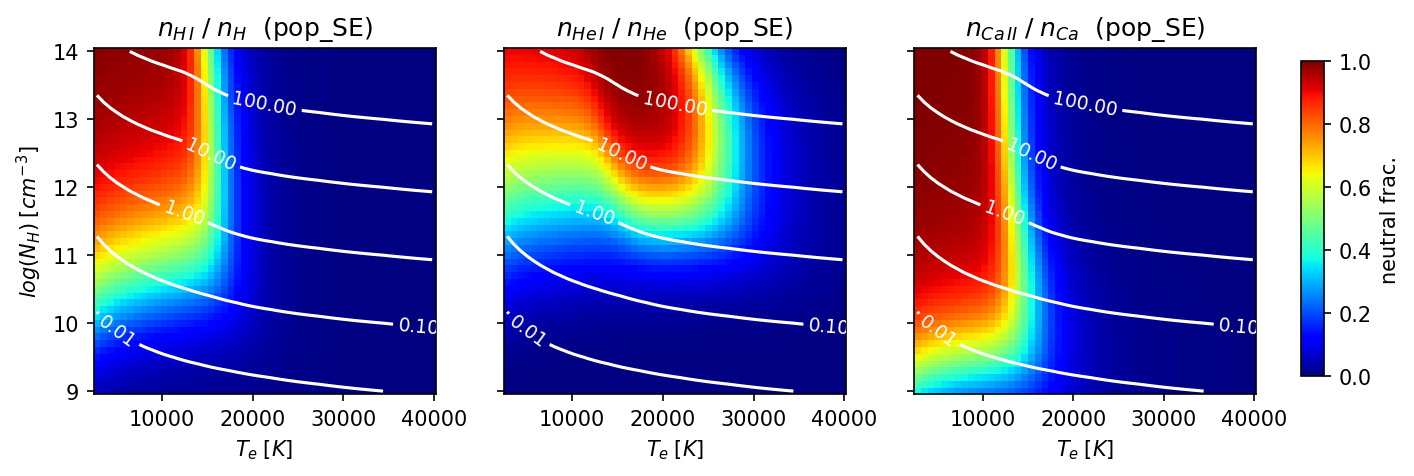

In [31]:
#  display neutral fraction of H and He on (Te, nH) plane
# load SE results 
import joblib
rH  = joblib.load(savdir+H_file) 
rHe = joblib.load(savdir+He_file)
rCa = joblib.load(savdir+Ca_file)
Nh_arr = rH['N_arr'] ;   nNh = Nh_arr.size
Te_arr = rH['Te_arr'] ;  nTe = Te_arr.size

#--- sum up neutral populations ---
pop = "pop_SE"
mask_HI = (atom_H.Level['stage'] == 1)
mask_HeI = (atom_He.Level['stage'] == 1)
mask_CaII = (atom_Ca.Level['stage'] == 2)
nHI = np.sum(rH[pop][mask_HI,:,:], axis=0)
nHeI = np.sum(rHe[pop][mask_HeI,:,:], axis=0)
nCaII = np.sum(rCa[pop][mask_CaII,:,:], axis=0)


Te,Nh = np.meshgrid(Te_arr,np.log10(Nh_arr))

Ne0      = 1.E-4 * Nh                # [/cm^{3}]
Ne = Ne0 + 10**Nh * rH[pop][-1,:,:]   # [/cm^{3}]
Pg = (10**Nh *1.107 + Ne)*Cst.k_*Te

fig, axs = plt.subplots(1,3, figsize=(10,3), dpi=150, sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.2)
cmap = "jet"   #  "inferno"
plevels = [0.01,0.1,1,10,100]

ax=axs[0]
mapH = ax.pcolormesh(Te,Nh,nHI,cmap=cmap,vmin=0,vmax=1.)
ax.set_title("$ n_{H\, I} \; / \; n_{H} $  ("+pop+")")
ax.set_ylabel("$log(N_{H}) \; [cm^{-3}]$")
ax.set_xlabel("$T_{e} \; [K]$")
ax.set_yticks([9,10,11,12,13,14])
CS = ax.contour(Te,Nh,Pg,levels=plevels,colors='w')
ax.clabel(CS, CS.levels, inline=True, fontsize=9, fmt='%4.2f')

ax=axs[1]
mapHe = ax.pcolormesh(Te,Nh,nHeI,cmap=cmap,vmin=0,vmax=1.)
ax.set_title("$ n_{He\, I} \; / \; n_{He} $  ("+pop+")")
ax.set_xlabel("$T_{e} \; [K]$")
CS = ax.contour(Te,Nh,Pg,levels=plevels,colors='w')
ax.clabel(CS, CS.levels, inline=True, fontsize=9, fmt='%4.2f')

ax=axs[2]
mapCa = ax.pcolormesh(Te,Nh,nCaII,cmap=cmap,vmin=0,vmax=1.)
ax.set_title("$ n_{Ca\, II} \; / \; n_{Ca} $  ("+pop+")")
ax.set_xlabel("$T_{e} \; [K]$")
CS = ax.contour(Te,Nh,Pg,levels=plevels,colors='w')
ax.clabel(CS, CS.levels, inline=True, fontsize=9, fmt='%4.2f')

cax = fig.add_axes([0.93,0.15,0.015,0.7])
fig.colorbar(mapH, cax=cax, orientation="vertical", label = "neutral frac.")

plt.show()

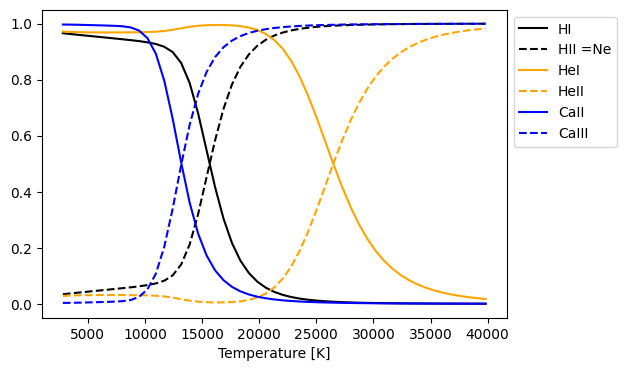

In [181]:
# plot SE_pop
# ['N_arr', 'Te_arr', 'pop_LTE', 'pop_SE', 'wl0', 'Line_mesh_idxs', 'wl_1D', 'prof_3D', 'tau_3D', 'src']
Nh0 = 1e13
j0 = np.argmin(np.abs(N_arr-Nh0))

fig, ax = plt.subplots(1,1,figsize=[6,4])

ax.plot(Te_arr,ｎHI[j0,:], color='black',label='HI')
ax.plot(Te_arr,1-ｎHI[j0,:], '--', color='black', label='HII =Ne')
ax.plot(Te_arr,nHeI[j0,:], color='orange', label='HeI')
ax.plot(Te_arr,1-nHeI[j0,:], '--', color='orange', label='HeII')
ax.plot(Te_arr,nCaII[j0,:], color='blue', label='CaII')
ax.plot(Te_arr,1-nCaII[j0,:], '--', color='blue', label='CaIII')


ax.set_xlabel('Temperature [K]')
#ax.set_yscale('log')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

## Intensity variation of selected lines on [$T_e, n_H$] plane

In [161]:
atom_He.Line['BIJ'][[60,61,62,76,77,91]]
atom_He.Line['BIJ'][[60,61,62,76,77,91]]
rHe['src'][[60,61,62,76,77,91],j0,k0]

array([9.11563067e+13, 9.11563254e+13, 9.11565849e+13, 9.11555365e+13,
       9.11557960e+13, 9.11454339e+13])

In [123]:
atom_He.Line['AJI'][92]

0.0

In [128]:
##  confirm the full solar spectrum common for Ｈ, He, Ca
print(Isolar.shape,  wls_air.shape)
line_list(atom_He)

(3754678,) (3754678,)
id   wavelength[A]  Aji[s-1]   lower level ctj    -     upper level ctj 
  3     3934.78  1.5E+08    ('1s2.2s2.2p6.3s2.3p6.4s', '2S', '1/2')  -  ('1s2.2s2.2p6.3s2.3p6.4p', '2P', '3/2')
  2     3969.59  1.4E+08    ('1s2.2s2.2p6.3s2.3p6.4s', '2S', '1/2')  -  ('1s2.2s2.2p6.3s2.3p6.4p', '2P', '1/2')
  6     8500.36  1.1E+06    ('1s2.2s2.2p6.3s2.3p6.3d', '2D', '3/2')  -  ('1s2.2s2.2p6.3s2.3p6.4p', '2P', '3/2')
  8     8544.43  9.9E+06    ('1s2.2s2.2p6.3s2.3p6.3d', '2D', '5/2')  -  ('1s2.2s2.2p6.3s2.3p6.4p', '2P', '3/2')
  5     8664.52  1.1E+07    ('1s2.2s2.2p6.3s2.3p6.3d', '2D', '3/2')  -  ('1s2.2s2.2p6.3s2.3p6.4p', '2P', '1/2')
# selected = 5


[{'id': 3,
  'w0_AA': 3934.7764386831495,
  'Aji': 147000000.0,
  'ctj1': ('1s2.2s2.2p6.3s2.3p6.4s', '2S', '1/2'),
  'ctj2': ('1s2.2s2.2p6.3s2.3p6.4p', '2P', '3/2')},
 {'id': 2,
  'w0_AA': 3969.5908468338266,
  'Aji': 140000000.0,
  'ctj1': ('1s2.2s2.2p6.3s2.3p6.4s', '2S', '1/2'),
  'ctj2': ('1s2.2s2.2p6.3s2.3p6.4p', '2P', '1/2')},
 {'id': 6,
  'w0_AA': 8500.357610345698,
  'Aji': 1110000.0,
  'ctj1': ('1s2.2s2.2p6.3s2.3p6.3d', '2D', '3/2'),
  'ctj2': ('1s2.2s2.2p6.3s2.3p6.4p', '2P', '3/2')},
 {'id': 8,
  'w0_AA': 8544.433694910716,
  'Aji': 9900000.0,
  'ctj1': ('1s2.2s2.2p6.3s2.3p6.3d', '2D', '5/2'),
  'ctj2': ('1s2.2s2.2p6.3s2.3p6.4p', '2P', '3/2')},
 {'id': 5,
  'w0_AA': 8664.520481185167,
  'Aji': 10600000.0,
  'ctj1': ('1s2.2s2.2p6.3s2.3p6.3d', '2D', '3/2'),
  'ctj2': ('1s2.2s2.2p6.3s2.3p6.4p', '2P', '1/2')}]

rH.keys()   dict_keys(['N_arr', 'Te_arr', 'pop_LTE', 'pop_SE', 'wl0', 'Line_mesh_idxs', 'wl_1D', 'prof_3D', 'tau_3D', 'src'])
rH[pop_SE].shape  (9, 51, 51)
HI . HeI . CaII . 

Text(1.0, 1.0, 'reference: $n_H$=1.0E+11, $T_e$=  8000')

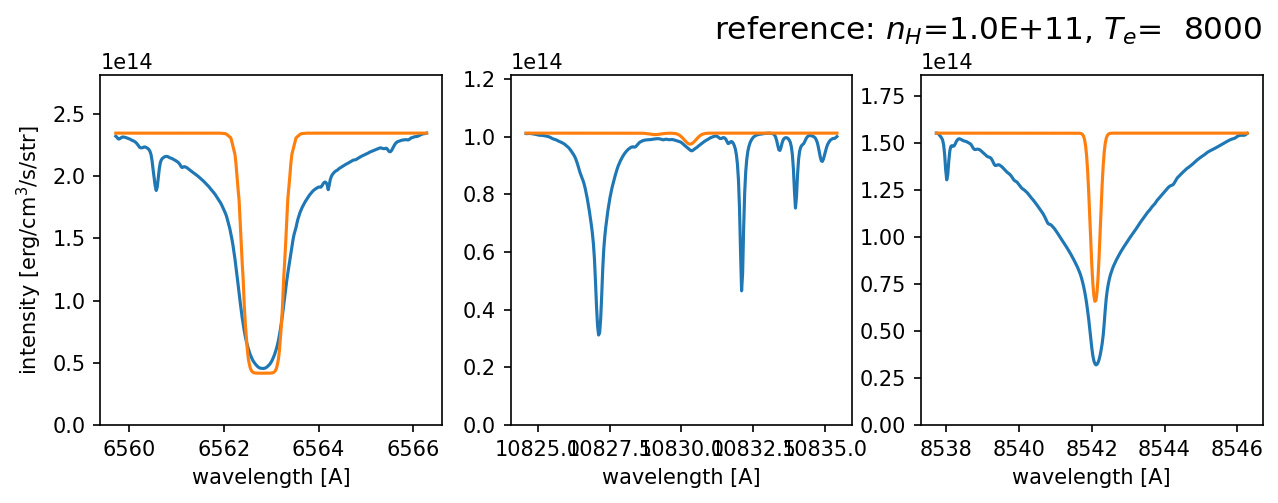

In [41]:
### define lines of interest & other params. ###
ls = [
    {'elem': 'HI',  'wl0': 6563.},
    #{'elem': 'HeI', 'wl0': 304.},
    #{'elem': 'HeI', 'wl0': 5877.},
    {'elem': 'HeI', 'wl0': 10830.},
    {'elem': 'CaII', 'wl0': 8542.},
    #{'elem': 'CaII', 'wl0': 3934.}
]
Te_ref = 8000.     # reference condition
Nh_ref = 1*1e11
bkg = 0   # switch of background radiation,  0: continuum, 1: solar spectrum
vmax = 150. ; dv = 1.  # km/s
#vmax = 500. ; dv = 1.  # km/s


# load SE results rH, rHe, rCa
import joblib
rH  = joblib.load(savdir+H_file) 
rHe = joblib.load(savdir+He_file)
rCa = joblib.load(savdir+Ca_file)
print('rH.keys()  ',rH.keys())
print('rH[pop_SE].shape ',rH["pop_SE"].shape)
rH['atom'] = atom_H
rHe['atom'] = atom_He
rCa['atom'] = atom_Ca
rs = {
    'HI':   rH,
    'HeI':  rHe,
    'CaII': rCa,
}

Nh_arr = rH['N_arr'] ;   nNh = Nh_arr.size
Te_arr = rH['Te_arr'] ;  nTe = Te_arr.size

nl = len(ls)
nw = 2*vmax/dv+1

#-------  make containers   -------
src = np.zeros([nl,nNh,nTe])
tau0 = np.zeros([nl,nNh,nTe])
nw = wlarr(5000.,vmax,dv).size
profs = np.zeros([nl,nw,nNh,nTe])
bkg_prof = np.zeros([nl,nw])
wls = np.zeros([nl,nw])
Isps = np.zeros([nl,nw])      # solar spectra
#----

for i in range(nl):
    wls[i,:] = wlarr(ls[i]['wl0'],vmax,dv)  # selected wavelength in air

#for i in range(nl):
#    ls[i].update({'profs': profs, 'tau0': tau0, 'src': src})    # <== add profs[:,:,:] to ls[:]

for i in range(nl):
    elem =ls[i]['elem']
    r = rs[elem]
    #print(r['tau_3D'][150,20,20])
    print(elem+' ',end='')
    wl = wls[i,:]
    tau = np.zeros(nw)
    w0 = BasicP.vacuum_to_air_(r['wl0'],'AA')  # calculated line center 

    ll = np.where((w0 > min(wl)) & (w0 < max(wl)))[0]
    Isp = np.interp(wl,wls_air,Isolar)
    Isps[i,:] = Isp
    if bkg == 0:
        bkg_prof1 = max(Isp) *np.ones(nw)
    else:
        bkg_prof1 = Isp
    bkg_prof[i,:] = bkg_prof1
    for j in range(nNh):
        for k in range(nTe):
            tau = 0.
            src0 = 0.
            profe = np.zeros(nw)
            for l in ll:
                #if r['atom'].Line['AJI'][l] < 1E-2: # skip forbidden line
                #    continue
                idx1 = r['Line_mesh_idxs'][l,0] 
                idx2 = r['Line_mesh_idxs'][l,1]
                wlm_air = BasicP.vacuum_to_air_(r['wl_1D'][idx1:idx2],'AA')
                tau1 = np.interp(wl, wlm_air, r['tau_3D'][idx1:idx2,j,k])
                src1 = r['src'][l,j,k]
                prof1 = src1 * (1.-np.exp(-tau1))
                #print('Ic, Src=',Ic,l.Src[j])
                tau += tau1
                profe += prof1
                if src1 > src0:
                    src0 = src1
            prof = bkg_prof1*np.exp(-tau) + profe
            profs[i,:,j,k] = prof
            #if ((not prof[0]>0) and (not prof[0]<=0)):
            #    assert False
            tau0[i,j,k] = np.max(tau)
            src[i,j,k] = src0
    print('. ',end='')

j0 = np.argmin(np.abs(Nh_arr-Nh_ref))
k0 = np.argmin(np.abs(Te_arr-Te_ref))
ref_prof = profs[:,:,j0,k0]


##-------  display reference spectra  ---------------
fig, axs = plt.subplots(1,nl, figsize=(10,10/nl-0.3), dpi=150)
plt.subplots_adjust(wspace=0.2)

ref_title = r"reference: $n_H$="+f"{Nh_arr[j0]:4.1E}"+", $T_e$="+f"{Te_arr[k0]:7.1F}"
for i in range(nl):
    axs[i].plot(wls[i,:],Isps[i,:])
    axs[i].plot(wls[i,:],ref_prof[i,:])
    #axs[i].plot(wl,tau)

    axs[i].set_xlabel("wavelength [A]", fontsize=10)
    if i == 0:
        axs[i].set_ylabel("intensity [erg/cm$^3$/s/str]", fontsize=10)
    axs[i].set_ylim(0,max(ref_prof[i,:])*1.2)

plt.title(r"reference: $n_H$="+f"{Nh_arr[j0]:4.1E}, $T_e$="+f"{Te_arr[k0]:6.0F}" ,loc='right',fontsize=15)




0 [625.40374121 601.2512841 ]
1 [601.2512841  591.26167285]
2 [591.26167285 591.2614056 ]
3 [591.2614056  591.25795109]
4 [591.25795109 581.35911079]
5 [581.35911079 545.60289708]
6 [545.60289708 540.79796989]
7 [540.79796989 538.75859649]
8 [538.75859649 537.20415792]
9 [537.20415792 537.20415067]
10 [537.20415067 537.20402307]
11 [537.20402307 537.19428438]
12 [537.19428438 535.66267599]
13 [535.66267599 525.35741258]
14 [525.35741258 523.59068756]
15 [523.59068756 522.83266907]
16 [522.83266907 522.21156571]
17 [522.21156571 522.20619083]
18 [  522.20619083 15568.80116474]
19 [15568.80116474 10819.51502916]
20 [10819.51502916 10819.42545075]
21 [10819.42545075 10818.26764739]
22 [10818.26764739  8863.83636117]
23 [8863.83636117 4275.92084705]
24 [4275.92084705 3997.56503971]
25 [3997.56503971 3886.77340465]
26 [3886.77340465 3809.19588965]
27 [3809.19588965 3809.195525  ]
28 [3809.195525  3809.1891098]
29 [3809.1891098  3808.69951241]
30 [3808.69951241 3793.6114514 ]
31 [3793.611451

IndexError: index 7965 is out of bounds for axis 0 with size 7965

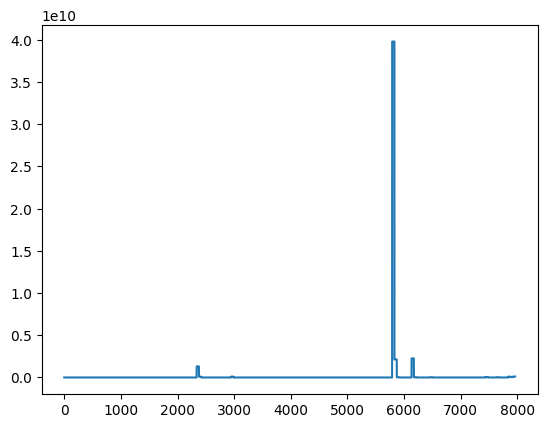

In [42]:
plt.plot(rHe['wl_1D'])
idxs = rHe['Line_mesh_idxs']
for i in range(idxs.shape[0]):
    print(i,rHe['wl_1D'][idxs[i,:]])
rHe.keys()

91156325446208.28

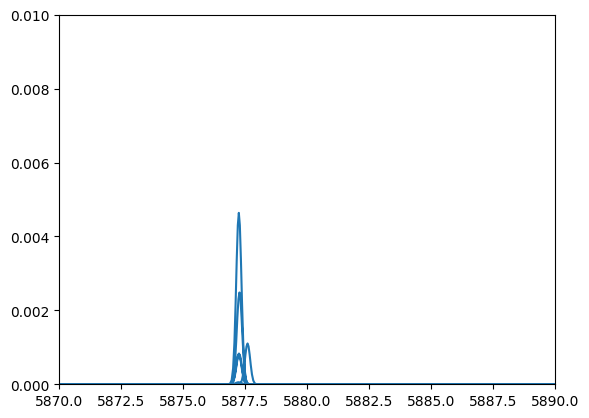

In [50]:
#ref_prof[i,:],profs[1,0,:,:]
plt.plot(rHe['wl_1D'],rHe['tau_3D'][:,j0,k0])
plt.xlim(5870,5890)
plt.ylim(0,0.01)
rHe['src'][61,j0,k0]

In [43]:
line_list(atom_He)

id   wavelength[A]  Aji[s-1]   lower level ctj    -     upper level ctj 
193      256.32  3.0E+09    ('1s', '2S', '1/2')  -  ('3p', '2P', '1/2+3/2')
191      303.78  1.0E+10    ('1s', '2S', '1/2')  -  ('2p', '2P', '1/2+3/2')
 13      537.03  5.9E+08    ('1s2', '1S', '0')  -  ('1s.3p', '1P', '1')
  5      584.33  1.8E+09    ('1s2', '1S', '0')  -  ('1s.2p', '1P', '1')
197     1640.36  3.0E+09    ('2s', '2S', '1/2')  -  ('3p', '2P', '1/2+3/2')
200     1640.45  1.0E+09    ('2p', '2P', '1/2+3/2')  -  ('3p', '2P', '1/2+3/2')
199     1640.48  1.0E+08    ('2p', '2P', '1/2+3/2')  -  ('3s', '2S', '1/2')
 34     3188.66  7.2E+06    ('1s.2s', '3S', '1')  -  ('1s.4p', '3P', '2+1+0')
 26     3889.74  1.0E+07    ('1s.2s', '3S', '1')  -  ('1s.3p', '3P', '2+1+0')
 68     4472.73  3.1E+07    ('1s.2p', '3P', '2')  -  ('1s.4d', '3D', '3+2+1')
 65     4714.46  1.6E+07    ('1s.2p', '3P', '2')  -  ('1s.4s', '3S', '1')
111     4923.30  2.7E+07    ('1s.2p', '1P', '1')  -  ('1s.4d', '1D', '2')
 48     5017.08  

[{'id': 193,
  'w0_AA': 256.31689650741026,
  'Aji': 3030000000.0,
  'ctj1': ('1s', '2S', '1/2'),
  'ctj2': ('3p', '2P', '1/2+3/2')},
 {'id': 191,
  'w0_AA': 303.7821566208585,
  'Aji': 10000000000.0,
  'ctj1': ('1s', '2S', '1/2'),
  'ctj2': ('2p', '2P', '1/2+3/2')},
 {'id': 13,
  'w0_AA': 537.0298209967417,
  'Aji': 587000000.0,
  'ctj1': ('1s2', '1S', '0'),
  'ctj2': ('1s.3p', '1P', '1')},
 {'id': 5,
  'w0_AA': 584.3342515525173,
  'Aji': 1830000000.0,
  'ctj1': ('1s2', '1S', '0'),
  'ctj2': ('1s.2p', '1P', '1')},
 {'id': 197,
  'w0_AA': 1640.3599233330617,
  'Aji': 3030000000.0,
  'ctj1': ('2s', '2S', '1/2'),
  'ctj2': ('3p', '2P', '1/2+3/2')},
 {'id': 200,
  'w0_AA': 1640.4523943043826,
  'Aji': 1040000000.0,
  'ctj1': ('2p', '2P', '1/2+3/2'),
  'ctj2': ('3p', '2P', '1/2+3/2')},
 {'id': 199,
  'w0_AA': 1640.4797745797207,
  'Aji': 101000000.0,
  'ctj1': ('2p', '2P', '1/2+3/2'),
  'ctj2': ('3s', '2S', '1/2')},
 {'id': 34,
  'w0_AA': 3188.6648257314387,
  'Aji': 7190000.0,
  'ctj1': 

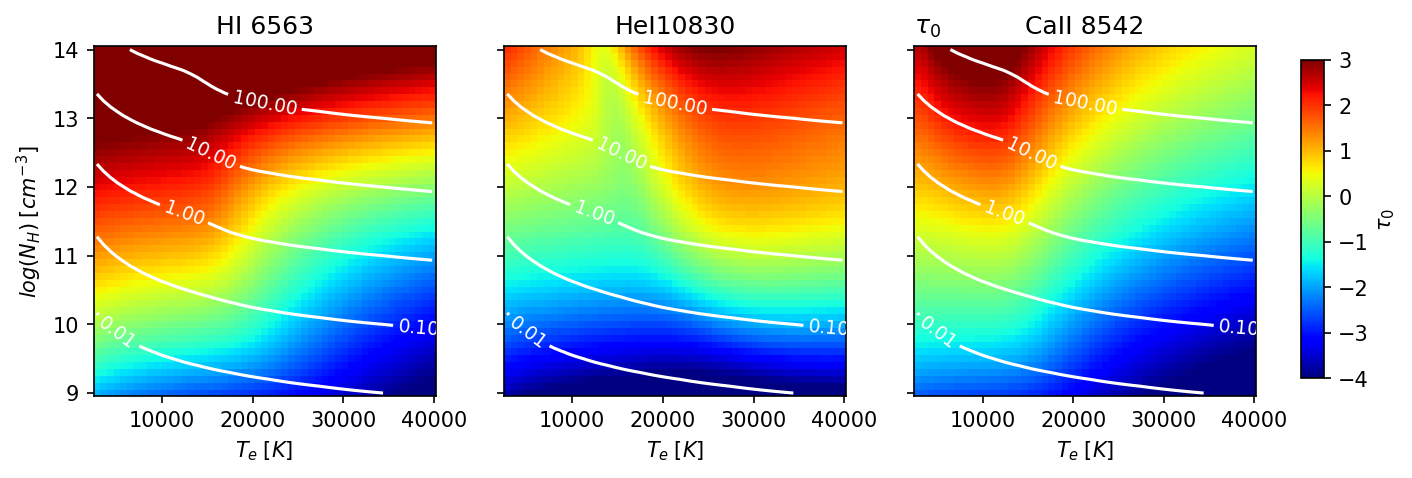

In [63]:
fig, axs = plt.subplots(1,nl, figsize=(10,10/nl-0.3), dpi=150, sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.2)
cmap = "jet"   #  "inferno"
plevels = [0.01,0.1,1,10,100]

Te,Nh = np.meshgrid(Te_arr,np.log10(Nh_arr))

Ne0      = 1.E-4 * Nh                # [/cm^{3}]
Ne = Ne0 + 10**Nh * rH[pop][-1,:,:]   # [/cm^{3}]
Pg = (10**Nh *1.107 + Ne)*Cst.k_*Te
ew = np.zeros([nNh,nTe])

for i in range(nl):
    ls1 = ls[i]
    refsum = np.sum(ref_prof[i,:])
    ew = (np.sum(profs[i,:,:,:],axis=0) - refsum)/refsum
    ax = axs[i]
    map1 = ax.pcolormesh(Te,Nh,np.log10(tau0[i,:,:]),cmap=cmap,vmin=-4,vmax=3.)
    #map1 = ax.pcolormesh(Te,Nh,np.log10(tau0[i,:,:]),cmap=cmap,vmin=-7,vmax=10.)
    #map1 = ax.pcolormesh(Te,Nh,ew,cmap=cmap,vmin=0,vmax=3.)
    ax.set_title(ls1['elem']+f"{ls1['wl0']:5.0f}")
    ax.set_xlabel("$T_{e} \; [K]$")
    if i == 0:
        ax.set_ylabel("$log(N_{H}) \; [cm^{-3}]$")
        ax.set_yticks([9,10,11,12,13,14])
    CS = ax.contour(Te,Nh,Pg,levels=plevels,colors='w')
    ax.clabel(CS, CS.levels, inline=True, fontsize=9, fmt='%4.2f')

#plt.title(r'$\tau_0$',loc='left',fontsize=12)
cax = fig.add_axes([0.93,0.15,0.015,0.7])
fig.colorbar(map1, cax=cax, orientation="vertical", label = r"$\tau_0$")


plt.show()

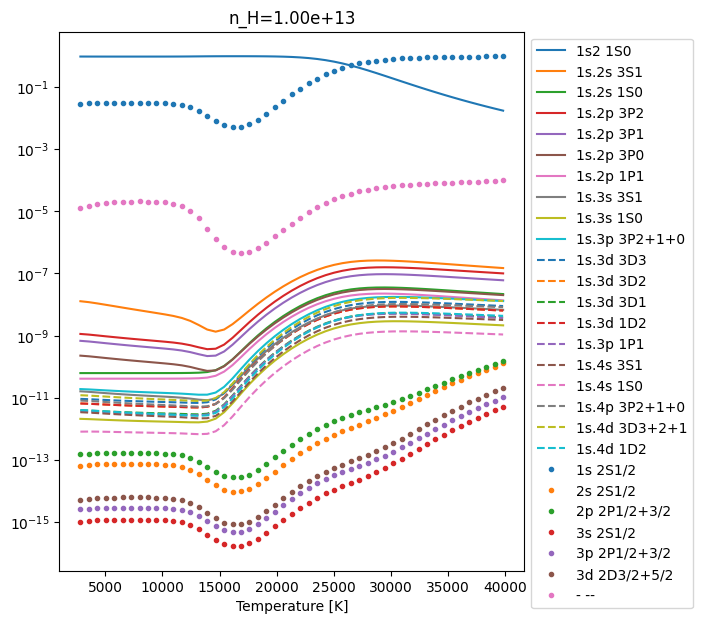

In [191]:
# plot SE_pop
# ['N_arr', 'Te_arr', 'pop_LTE', 'pop_SE', 'wl0', 'Line_mesh_idxs', 'wl_1D', 'prof_3D', 'tau_3D', 'src']
Nh0 = 1e13
r = rHe
N_arr = r["N_arr"]
Te_arr = r["Te_arr"]
j0 = np.argmin(np.abs(N_arr-Nh0))
nN = len(N_arr)

pop_SE = r["pop_SE"][:,j0,:]
levels = atom_He._ctj_table.Level

nLevel = pop_SE.shape[0]
fig, ax = plt.subplots(1,1,figsize=[6,7])
styles = ['-','--','.']
for j in range(nLevel):
    id = levels[j][0]+' '+levels[j][1]+levels[j][2]
    style = styles[j // 10]
    ax.plot(Te_arr,pop_SE[j,:],style, label=id)

ax.set_xlabel('Temperature [K]')
ax.set_yscale('log')
ax.set_title(f'n_H={Nh0:.2e}')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

In [148]:
atom_He._ctj_table.Level[0][0]#.__len__()

'1s2'

27

In [145]:
ew = np.sum(profs[0,:,:,:],axis=0)
ew.shape

(51, 51)

rH.keys()   dict_keys(['N_arr', 'Te_arr', 'pop_LTE', 'pop_SE', 'wl0', 'Line_mesh_idxs', 'wl_1D', 'prof_3D', 'tau_3D', 'src'])
rH[pop_SE].shape  (9, 51, 51)
reference: $n_H$=1.0E+11, $T_e$= 8000.0
HI . HeI . . . CaII . 

Text(1.0, 1.0, 'reference: $n_H$=1.0E+11, $T_e$=  8000')

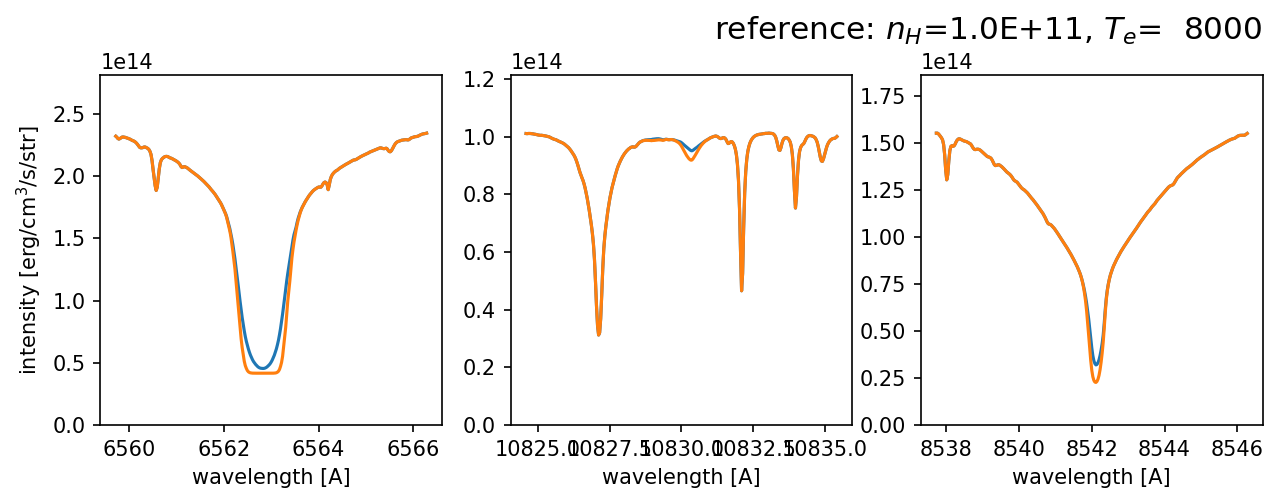

In [402]:
# switch of background radiation
bkg = 1   #  0: continuum, 1: solar spectrum

# load SE results 

import joblib
rH  = joblib.load(savdir+H_file) 
rHe = joblib.load(savdir+He_file)
rCa = joblib.load(savdir+Ca_file)

print('rH.keys()  ',rH.keys())
print('rH[pop_SE].shape ',rH["pop_SE"].shape)

### define lines of interest ###
#  Isolar[:], wls_solar_air[:] in A, common for H,He,Ca needed
ls = [
    {'elem': 'HI',  'wl0': 6563.},
    {'elem': 'HeI', 'wl0': 10830.},
    {'elem': 'CaII', 'wl0': 8542.}
    #{'elem':'CaII', 'wl0': 3934.}
]

nl = len(ls)
vmax = 150. ; dv = 1.  # km/s

rs = {
    'HI': rH,
    'HeI': rHe,
    'CaII': rCa,
}

## display reference spectuam ###
Te_ref = 8000.
Nh_ref = 1*1e11
j0 = np.argmin(np.abs(Nh_arr-Nh_ref))
k0 = np.argmin(np.abs(Te_arr-Te_ref))
print(r"reference: $n_H$="+f"{Nh_arr[j0]:4.1E}"+", $T_e$="+f"{Te_arr[k0]:7.1F}")

fig, axs = plt.subplots(1,nl, figsize=(10,10/nl-0.3), dpi=150)
plt.subplots_adjust(wspace=0.2)

j=j0 ;  k=k0   # for reference

for i in range(nl):
    elem =ls[i]['elem']
    print(elem+' ',end='')
    r = rs[elem]
    wl = wlarr(ls[i]['wl0'],vmax,dv)  # selected wavelength in air
    nw = wl.size
    profe = np.zeros(nw)
    tau = np.zeros(nw)
    w0 = BasicP.vacuum_to_air_(r['wl0'],'AA')  # calculated line center 

    ll = np.where((w0 > min(wl)) & (w0 < max(wl)))[0]
    Isp = np.interp(wl,wls_air,Isolar)
    for l in ll:
        idx1 = r['Line_mesh_idxs'][l,0] 
        idx2 = r['Line_mesh_idxs'][l,1]
        wlm_air = BasicP.vacuum_to_air_(r['wl_1D'][idx1:idx2],'AA')
        tau1 = np.interp(wl, wlm_air, r['tau_3D'][idx1:idx2,j,k])
        prof1 = r['src'][l,j,k] * (1.-np.exp(-tau1))
        #print('Ic, Src=',Ic,l.Src[j])
        tau += tau1
        profe += prof1
        print('. ',end='')
    if bkg == 0:
        backrad = max(Isp) *np.ones(nw)
    else:
        backrad = Isp
    prof = backrad*np.exp(-tau) + profe
    ls[i].update({'ref_prof': prof, 'backrad': backrad})  # <== add backrad[:] to ls[:]

    axs[i].plot(wl,Isp)
    axs[i].plot(wl,prof)
    #axs[i].plot(wl,tau)

    axs[i].set_xlabel("wavelength [A]", fontsize=10)
    if i == 0:
        axs[i].set_ylabel("intensity [erg/cm$^3$/s/str]", fontsize=10)
    axs[i].set_ylim(0,max(prof)*1.2)

plt.title(r"reference: $n_H$="+f"{Nh_arr[j0]:4.1E}, $T_e$="+f"{Te_arr[k0]:6.0F}" ,loc='right',fontsize=15)


In [401]:
# get profs[Nh,Te]

nTe = len(rH['Te_arr'])
nNh = len(rH['N_arr'])

src = np.zeros([nNh,nTe])
tau0 = np.zeros([nNh,nTe])
#for i in range(nl):
#    ls[i].update({'profs': profs, 'tau0': tau0, 'src': src})    # <== add profs[:,:,:] to ls[:]

for i in range(nl):
    elem =ls[i]['elem']
    r = rs[elem]
    #print(r['tau_3D'][150,20,20])
    print(elem+' ',end='')
    wl = wlarr(ls[i]['wl0'],vmax,dv)  # selected wavelength in air
    nw = wl.size
    profe = np.zeros(nw)
    tau = np.zeros(nw)
    profs = np.zeros([nw,nNh,nTe])
    w0 = BasicP.vacuum_to_air_(r['wl0'],'AA')  # calculated line center 

    ll = np.where((w0 > min(wl)) & (w0 < max(wl)))[0]
    Isp = np.interp(wl,wls_air,Isolar)
    if bkg == 0:
        backrad = max(Isp) *np.ones(nw)
    else:
        backrad = Isp
    for j in range(nNh):
        for k in range(nTe):
            tau = 0.
            src0 = 0.
            for l in ll:
                idx1 = r['Line_mesh_idxs'][l,0] 
                idx2 = r['Line_mesh_idxs'][l,1]
                wlm_air = BasicP.vacuum_to_air_(r['wl_1D'][idx1:idx2],'AA')
                tau1 = np.interp(wl, wlm_air, r['tau_3D'][idx1:idx2,j,k])
                src1 = r['src'][l,j,k]
                prof1 = src1 * (1.-np.exp(-tau1))
                #print('Ic, Src=',Ic,l.Src[j])
                tau += tau1
                profe += prof1
                if src1 > src0:
                    src0 = src1
            prof = backrad*np.exp(-tau) + profe
            profs[:,j,k] = prof
            tau0[j,k] = np.max(tau)
            src[j,k] = src0
    print('. ',end='')
    ls[i].update({'profs': profs, 'tau0': tau0, 'src': src})    # <== add profs[:,:,:] to ls[:]
    #ls[i]['tau0'][:,:] = tau0
    print(i)
    print(ls[0]['src'][25,:])



HI . 0
[4.12278080e+13 4.12740102e+13 4.13366302e+13 4.14209820e+13
 4.14908535e+13 4.15648520e+13 4.16493555e+13 4.17460734e+13
 4.18587985e+13 4.20005603e+13 4.21850491e+13 4.24434391e+13
 4.28410111e+13 4.34962071e+13 4.45785358e+13 4.64688402e+13
 4.97816391e+13 5.52864597e+13 6.47173414e+13 7.90620892e+13
 9.92209681e+13 1.25005152e+14 1.56862887e+14 1.94908472e+14
 2.39188162e+14 2.89664969e+14 3.46201735e+14 4.08559899e+14
 4.76411752e+14 5.49489296e+14 6.27341188e+14 7.09316085e+14
 7.94872036e+14 8.83450088e+14 9.74507758e+14 1.06752456e+15
 1.16200210e+15 1.25749822e+15 1.35360137e+15 1.44994951e+15
 1.54621075e+15 1.64205625e+15 1.73695627e+15 1.83103034e+15
 1.92410266e+15 2.01621405e+15 2.10732429e+15 2.19708527e+15
 2.28541997e+15 2.37226603e+15 2.45757952e+15]
HeI . 1
[4.73149989e+13 4.75305590e+13 4.78207588e+13 4.81708964e+13
 4.85610091e+13 4.89753282e+13 4.94024317e+13 4.98338926e+13
 5.02659880e+13 5.06966634e+13 5.11244654e+13 5.15517206e+13
 5.19985176e+13 5.24964

In [68]:
#******  calculate populations in SE & LTS on (Te, Nh) ******
#-- reference 
Te0 = 8000.
Nh0 = 1*1e11
Ne0 = 2e10

nTe = 51 ;  Te_arr = np.linspace(2000, 40000, nTe)
nNh = 51 ;  Nh_arr = np.logspace(9, 14, nNh)
Vd = 0.
Vt = 5e5            #   cm/s
depth = 1.E3 * 1.E5 #   km *1e5

for i in range(nl):
    ls1 = ls[i]
    if ls1['elem'] =='H':
        pop_arr, l_arr = popl_con(atom_H,nNh, nTe, ls1['wl'].size)
    elif ls1['elem'] =='He':
        pop_arr, l_arr = popl_con(atom_He,nNh, nTe, ls1['wl'].size)
    elif ls1['elem'] =='Ca':
        pop2D, l_arr = popl_con(atom_Ca,nNh, nTe, ls1['wl'].size)
    ls1.update({'pop_arr': pop_arr, 'l_arr': l_arr})
    


ls[0].keys()
#zlen(l_arr("popl_arr"))
#len(ls)
#ls['elem']

dict_keys(['elem', 'wl0', 'wl', 'wl_air', 'Isolar', 'Ic', 'intens', 'tau', 'src', 'pop_arr', 'l_arr'])

## Calc. SE and line intensities on [$T_e, n_H$] plane 

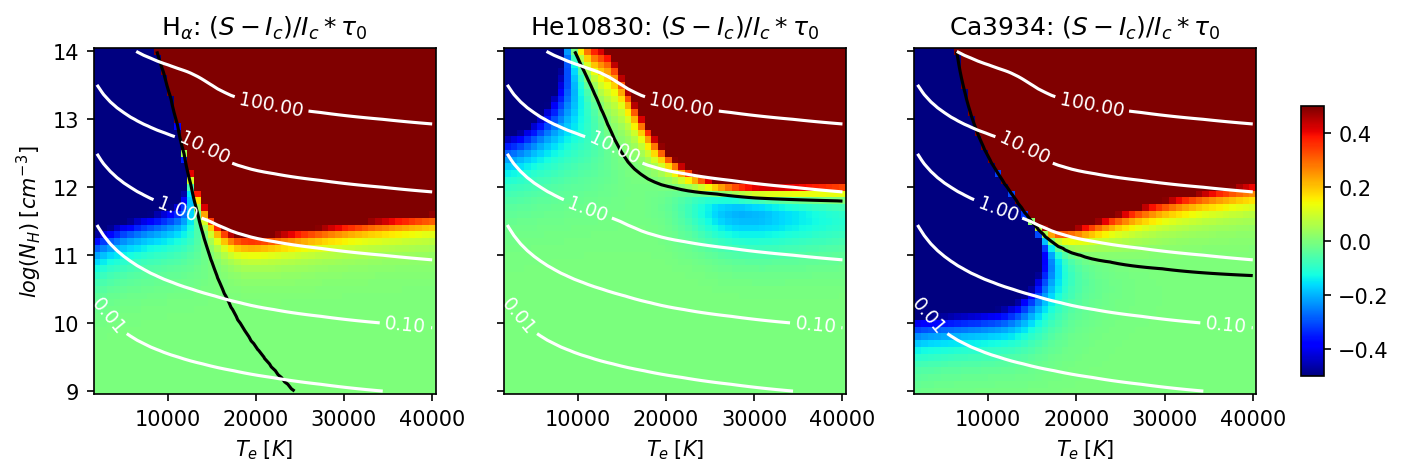

In [70]:
fig, axs = plt.subplots(1,3, figsize=(10,3), dpi=150, sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.2)
cmap = "jet"   #  "inferno"
vmx = 0.5

ax=axs[0]
s6563 = (l_arr_H["src"]-Ic6563)/Ic6563 *np.max(l_arr_H["tau"],axis=0)
sH = ax.pcolormesh(Te,Nh,s6563,cmap=cmap,vmin=-vmx,vmax=vmx)
ax.set_title(r"H$_\alpha$: $(S-I_c)/I_c * \tau_0$")
ax.set_ylabel("$log(N_{H}) \; [cm^{-3}]$")
ax.set_xlabel("$T_{e} \; [K]$")
ax.set_yticks([9,10,11,12,13,14])
c1 = ax.contour(Te,Nh,s6563,levels=[0],colors='black')
CS = ax.contour(Te,Nh,Pg,levels=plevels,colors='w')
ax.clabel(CS, CS.levels, inline=True, fontsize=9, fmt='%4.2f')

ax=axs[1]
s10830 = (l_arr_He["src"]-Ic10830)/Ic10830 *np.max(l_arr_He["tau"],axis=0)
sHe = ax.pcolormesh(Te,Nh,s10830,cmap=cmap,vmin=-vmx,vmax=vmx)
ax.set_title(r"He10830: $(S-I_c)/I_c * \tau_0$")
ax.set_xlabel("$T_{e} \; [K]$")
c1 = ax.contour(Te,Nh,s10830,levels=[0],colors='black')
CS = ax.contour(Te,Nh,Pg,levels=plevels,colors='w')
ax.clabel(CS, CS.levels, inline=True, fontsize=9, fmt='%4.2f')

ax=axs[2]
#s8542 = (l_arr_Ca["src"]-Ic8542)/Ic8542 *np.max(l_arr_Ca["tau"],axis=0)
#sCa = ax.pcolormesh(Te,Nh,s8542,cmap=cmap,vmin=-vmx,vmax=vmx)
#ax.set_title(r"Ca8542: $(S-I_c)/I_c * \tau_0$")
#ax.set_xlabel("$T_{e} \; [K]$")
#c1 = ax.contour(Te,Nh,s8542,levels=[0],colors='black')
s3934 = (l_arr_Ca["src"]-Ic3934)/Ic3934 *np.max(l_arr_Ca["tau"],axis=0)
sCa = ax.pcolormesh(Te,Nh,s3934,cmap=cmap,vmin=-vmx,vmax=vmx)
ax.set_title(r"Ca3934: $(S-I_c)/I_c * \tau_0$")
ax.set_xlabel("$T_{e} \; [K]$")
c1 = ax.contour(Te,Nh,s3934,levels=[0],colors='black')
CS = ax.contour(Te,Nh,Pg,levels=plevels,colors='w')
ax.clabel(CS, CS.levels, inline=True, fontsize=9, fmt='%4.2f')

cax = fig.add_axes([0.93,0.15,0.015,0.6])
fig.colorbar(sH, cax=cax, orientation="vertical")

In [39]:
l = line_list(atom_Ca)

id   wavelength[A]  Aji[s-1]   lower level ctj    -     upper level ctj 
  3     3934.78  1.5E+08    ('1s2.2s2.2p6.3s2.3p6.4s', '2S', '1/2')  -  ('1s2.2s2.2p6.3s2.3p6.4p', '2P', '3/2')
  2     3969.59  1.4E+08    ('1s2.2s2.2p6.3s2.3p6.4s', '2S', '1/2')  -  ('1s2.2s2.2p6.3s2.3p6.4p', '2P', '1/2')
  6     8500.36  1.1E+06    ('1s2.2s2.2p6.3s2.3p6.3d', '2D', '3/2')  -  ('1s2.2s2.2p6.3s2.3p6.4p', '2P', '3/2')
  8     8544.43  9.9E+06    ('1s2.2s2.2p6.3s2.3p6.3d', '2D', '5/2')  -  ('1s2.2s2.2p6.3s2.3p6.4p', '2P', '3/2')
  5     8664.52  1.1E+07    ('1s2.2s2.2p6.3s2.3p6.3d', '2D', '3/2')  -  ('1s2.2s2.2p6.3s2.3p6.4p', '2P', '1/2')
# selected = 5


Line# = 7
Line# = 21
Line# = 3


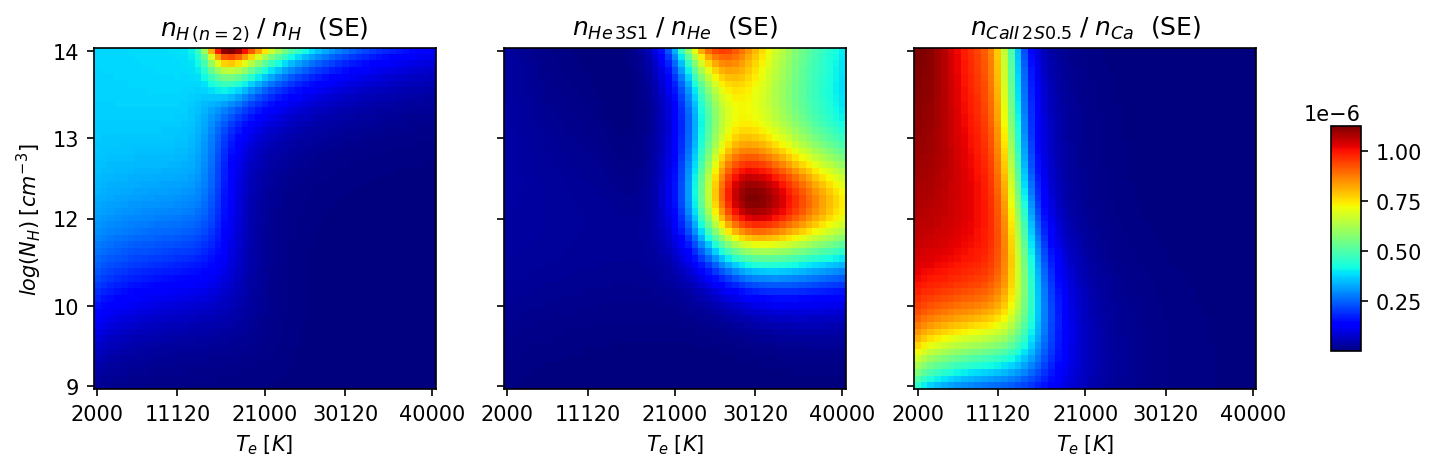

In [40]:
#********************************************************
#  lower level populations,  Ha and 10830,  

lidx_H,lower_H,uidx_H,upper_H = level_info(atom_H, 6563.)
lidx_He,lower_He,uidx_He,upper_He = level_info(atom_He,10830.3)
lidx_Ca,lower_Ca,uidx_Ca,upper_Ca = level_info(atom_Ca,3934.7)

EQ ="SE"
nH_l = pop_arr_H[EQ][lidx_H,:,:]
nHe_l = pop_arr_He[EQ][lidx_He,:,:]
nCa_l = pop_arr_Ca[EQ][lidx_Ca,:,:]


#fig, axs = plt.subplots(1,2, figsize=(8,4), dpi=150, sharex=True, sharey=True)
fig, axs = plt.subplots(1,3, figsize=(10,3), dpi=150, sharex=True, sharey=True)

plt.subplots_adjust(wspace=0.2)
cmap = "jet"   #  "inferno"
ax=axs[0]
#mapH = ax.pcolormesh(Te_arr,Nh_arr,nHI,cmap=cmap,vmin=0,vmax=1.)
im_H = ax.imshow(nH_l, cmap=cmap, origin="lower")#, vmin=0, vmax=1.)
Plotting.set_imshow_ticks_(ax, Te_arr, axis='x',points=5, fmt='%1.0f',rot=0)
Plotting.set_imshow_ticks_(ax, np.log10(Nh_arr), axis='y', points=5, fmt='%1.0f',rot=0)

ax.set_title("$ n_{H\, (n=2)} \; / \; n_{H} $  ("+EQ+")")
ax.set_ylabel("$log(N_{H}) \; [cm^{-3}]$")
ax.set_xlabel("$T_{e} \; [K]$")

ax = axs[1]
im_He = ax.imshow(nHe_l, cmap=cmap, origin="lower")#, vmin=0, vmax=1.)
ax.set_title("$ n_{He\, 3S1} \; / \; n_{He} $  ("+EQ+")")
ax.set_xlabel("$T_{e} \; [K]$")

ax = axs[2]
im_He = ax.imshow(nCa_l, cmap=cmap, origin="lower")#, vmin=0, vmax=1.)
ax.set_title("$ n_{CaII\, 2S0.5} \; / \; n_{Ca} $  ("+EQ+")")
ax.set_xlabel("$T_{e} \; [K]$")

cax = fig.add_axes([0.95,0.2,0.02,0.5])
fig.colorbar(im_H, cax=cax, orientation="vertical")

plt.show()

Text(0.5, 1.0, '$n_H=$1.0E+10 [cm-3]')

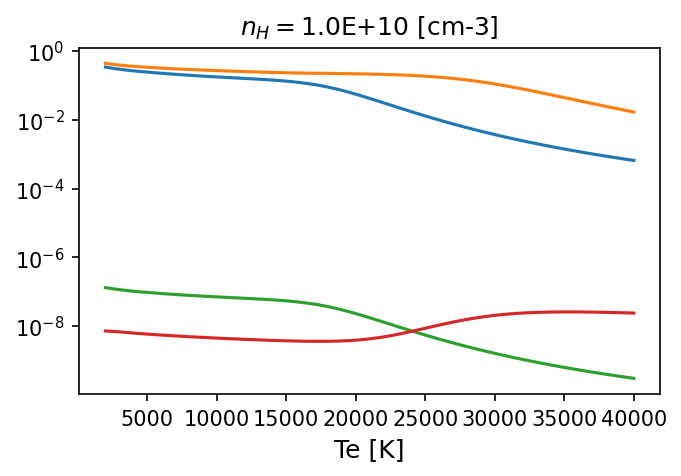

In [41]:
#******************************************************
#  plot population;  neutoral, lower level of Ha & 10830  

j = 10  #  Nh[j]

fig, ax = plt.subplots(1,1, figsize=[5,3], dpi=150)
ax.plot(Te_arr,nHI[j,:],label='HI')
ax.plot(Te_arr,nHeI[j,:],label='HeI')
ax.plot(Te_arr,nH_l[j,:],label='H (n=2)')
ax.plot(Te_arr,nHe_l[j,:],label='He ('+lower_He+')')

ax.set_yscale("log")
ax.set_xlabel("Te [K]", fontsize=12)
plt.title(f"$n_H=${Nh_arr[j]:5.1E} [cm-3]")
plt.legend()

# SE with (Pg, Te)

In [42]:
#******  calculate populations in SE & LTE on (Te, Pg) ******
nTe = 51
Te_arr = np.linspace(2000, 50000, nTe)
nPg = nTe
Pg_arr = np.logspace(-2, 3, nPg)   # dyn/cm^2
Vd = 0.
Vt = 5e5            #   cm/s
depth = 1.E3 * 1.E5 #   km *1e5

pop_arr_H, l_arr_H = popl_con(atom_H,nPg, nTe,w6563.size)
pop_arr_He, l_arr_He = popl_con(atom_He,nPg, nTe,w10830.size)
pop_arr_Ca, l_arr_Ca = popl_con(atom_Ca,nPg, nTe,w8542.size)
Ne_arr = np.empty((nPg, nTe), dtype="float64")

ampl = 1
solar_spec_H = enhance_EUV(solar_spec_H0,wMesh_H,ampl)
solar_spec_He = enhance_EUV(solar_spec_He0,wMesh_He,ampl)
solar_spec_Ca = enhance_EUV(solar_spec_Ca0,wMesh_Ca,ampl)

for j in range(nPg):  
#for j in (17,): #range(nPg):  
    Pg = Pg_arr[j]
    for k in range(nTe):
        print(f'\r {j}/{nPg}, {k}/{nTe}', end='\r')
        Te = Te_arr[k]
        slab = Atmosphere.Atmosphere0D(Pg=Pg, Nh=1e11, Ne=1e10, Te=Te, Vd=Vd, Vt=Vt, use_Tr=False)     # slab 
        # slab = Atmosphere.Atmosphere0D(Nh=Nh, Ne=Ne, Te=Te, Vd=Vd, Vt=Vt, use_Tr=False)     # slab 
        
        SE_H, Rate_H = SELib.cal_SE_with_Pg_Te_(atom_H, slab, wMesh_H, solar_spec_H, None)  #  level populations etc.
        lH = CloudModel.SE_to_slab_0D_(atom_H, slab, SE_H, depth=depth)      # hydrogen lines intensity
        l6563 = extract_line(lH,w6563,Ic=Ic6563)
        l_arr_H["intens"][:,j,k] = l6563["intens"]
        l_arr_H["tau"][:,j,k] = l6563["tau"]
        l_arr_H["src"][j,k] = l6563["src"]
        #print('H')

        SE_Ca, Rate_Ca = SELib.cal_SE_with_Pg_Te_(atom_Ca, slab, wMesh_Ca, solar_spec_Ca, SE_H.n_SE)  #  level populations etc.
        lCa = CloudModel.SE_to_slab_0D_(atom_Ca, slab, SE_Ca, depth=depth)      # hydrogen lines intensity
        l8542 = extract_line(lCa,w8542,Ic=Ic8542)
        l_arr_Ca["intens"][:,j,k] = l8542["intens"]
        l_arr_Ca["tau"][:,j,k] = l8542["tau"]
        l_arr_Ca["src"][j,k] = l8542["src"]

        SE_He, Rate_He = SELib.cal_SE_with_Pg_Te_(atom_He, slab, wMesh_He, solar_spec_He, SE_H.n_SE)  #  level populations etc.
        lHe = CloudModel.SE_to_slab_0D_(atom_He, slab, SE_He, depth=depth)      # hydrogen lines intensity
        l10830 = extract_line(lHe,w10830,Ic=Ic10830)
        l_arr_He["intens"][:,j,k] = l10830["intens"]
        l_arr_He["tau"][:,j,k] = l10830["tau"]
        l_arr_He["src"][j,k] = l10830["src"]

        Ne_arr[j,k] = atmos.Ne
        pop_arr_H["LTE"][:,j,k] = SE_H.n_LTE[:]
        pop_arr_H["SE"][:,j,k] = SE_H.n_SE[:]
        pop_arr_He["LTE"][:,j,k] = SE_He.n_LTE[:]
        pop_arr_He["SE"][:,j,k] = SE_He.n_SE[:]
        pop_arr_Ca["LTE"][:,j,k] = SE_Ca.n_LTE[:]
        pop_arr_Ca["SE"][:,j,k] = SE_Ca.n_SE[:]


wleuv= 5.04e-06
wleuv= 5.04e-06
wleuv= 5.04e-06


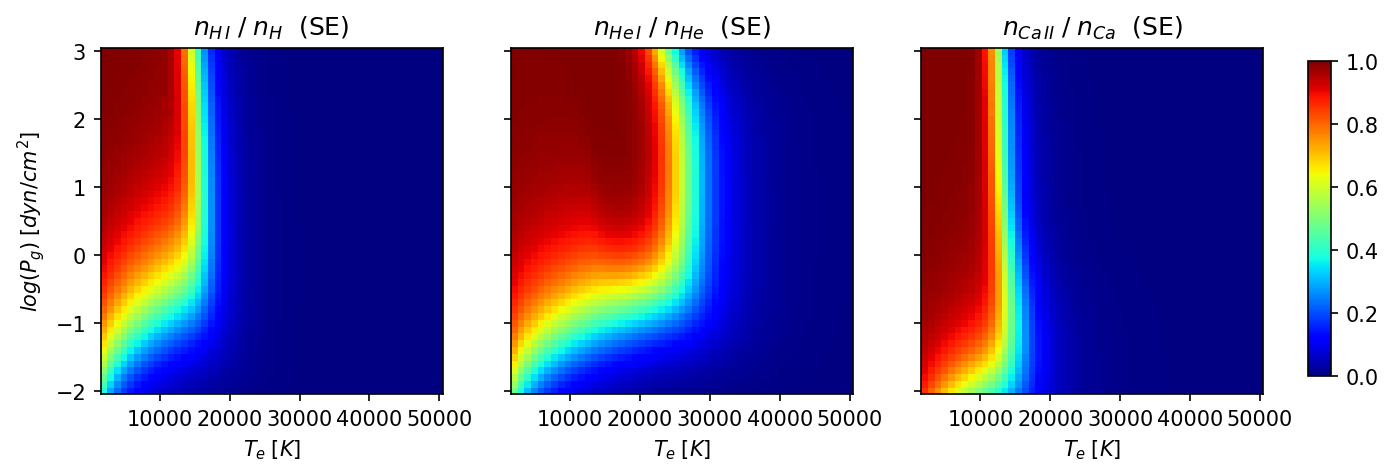

In [43]:
#  display neutral fraction of H and He on (Te, nH) plane

#--- sum up neutral populations ---
EQ = "SE"
mask_HI = (atom_H.Level['stage'] == 1)
mask_HeI = (atom_He.Level['stage'] == 1)
mask_CaII = (atom_Ca.Level['stage'] == 2)
nHI = np.sum(pop_arr_H[EQ][mask_HI,:,:], axis=0)
nHeI = np.sum(pop_arr_He[EQ][mask_HeI,:,:], axis=0)
nCaII = np.sum(pop_arr_Ca[EQ][mask_CaII,:,:], axis=0)
nH_l = pop_arr_H[EQ][lidx_H,:,:]
nHe_l = pop_arr_He[EQ][lidx_He,:,:]
nCa_l = pop_arr_Ca[EQ][lidx_Ca,:,:]



Te,Pg = np.meshgrid(Te_arr,np.log10(Pg_arr))

#Ne0      = 1.E-4 * Nh                # [/cm^{3}]
#Ne = Ne0 + 10**Nh * pop_arr_H[EQ][-1,:,:]   # [/cm^{3}]

fig, axs = plt.subplots(1,3, figsize=(10,3), dpi=150, sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.2)
cmap = "jet"   #  "inferno"

ax=axs[0]
mapH = ax.pcolormesh(Te,Pg,nHI,cmap=cmap,vmin=0,vmax=1.)
ax.set_title("$ n_{H\, I} \; / \; n_{H} $  ("+EQ+")")
ax.set_ylabel("$log(P_{g}) \; [dyn / cm^{2}]$")
ax.set_xlabel("$T_{e} \; [K]$")
ax.set_yticks([-2,-1,0,1,2,3,4])

ax=axs[1]
mapHe = ax.pcolormesh(Te,Pg,nHeI,cmap=cmap,vmin=0,vmax=1.)
ax.set_title("$ n_{He\, I} \; / \; n_{He} $  ("+EQ+")")
ax.set_xlabel("$T_{e} \; [K]$")

ax=axs[2]
mapCa = ax.pcolormesh(Te,Pg,nCaII,cmap=cmap,vmin=0,vmax=1.)
ax.set_title("$ n_{Ca\, II} \; / \; n_{Ca} $  ("+EQ+")")
ax.set_xlabel("$T_{e} \; [K]$")

cax = fig.add_axes([0.93,0.15,0.015,0.7])
fig.colorbar(mapH, cax=cax, orientation="vertical")


plt.show()

Text(0.5, 1.0, 'Neutral & lower level fraction  $P_g=$3.2E-01 [dyn / cm-2]')

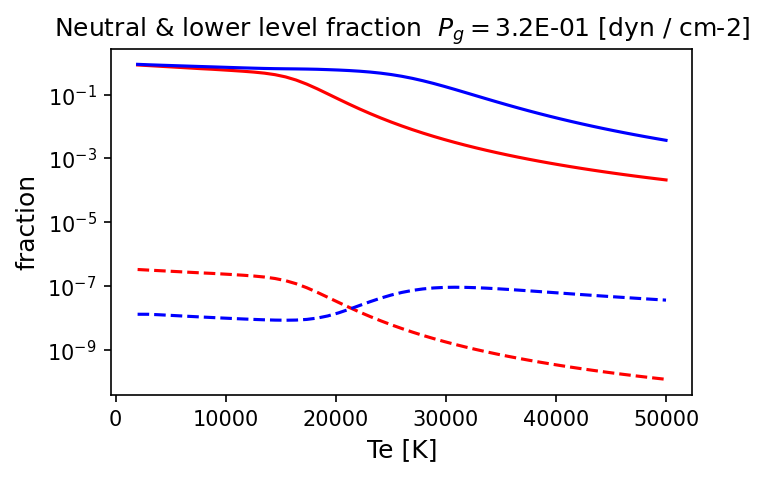

In [44]:
#******************************************************
#  plot neutoral fraction, lower level of Ha & 10830  

j = 15  #  Pg[j]

fig, ax = plt.subplots(1,1, figsize=[5,3], dpi=150)
ax.plot(Te_arr,nHI[j,:],label='HI',color='red')
#ax.plot(Te_arr,nCaII[j,:],label='CaII')
ax.plot(Te_arr,nHeI[j,:],label='HeI',color='blue')

ax.plot(Te_arr,nH_l[j,:],'--',label='H (n=2)',color='red')
#ax.plot(Te_arr,nCa_l[j,:],label='CaII (ground)')
ax.plot(Te_arr,nHe_l[j,:],'--',label='He ('+lower_He+')',color='blue')

ax.set_yscale("log")
#ax.set_ylim([0,1])
ax.set_xlabel("Te [K]", fontsize=12)
ax.set_ylabel("fraction", fontsize=12)
plt.title(f"Neutral & lower level fraction  $P_g=${Pg_arr[j]:5.1E} [dyn / cm-2]")
#plt.legend()

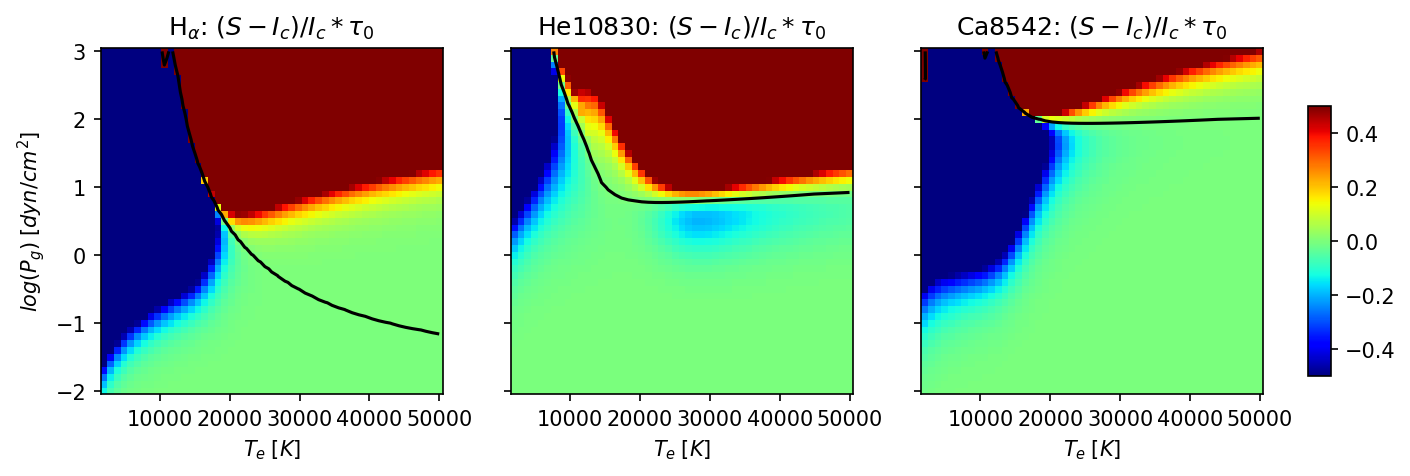

In [45]:
##  display (S-I_c)/I_c * tau 

fig, axs = plt.subplots(1,3, figsize=(10,3), dpi=150, sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.2)
cmap = "jet"   #  "inferno"
vmx = 0.5

ax=axs[0]
s6563 = (l_arr_H["src"]-Ic6563)/Ic6563 *np.max(l_arr_H["tau"],axis=0)
sH = ax.pcolormesh(Te,Pg,s6563,cmap=cmap,vmin=-vmx,vmax=vmx)
ax.set_title(r"H$_\alpha$: $(S-I_c)/I_c * \tau_0$")
ax.set_ylabel("$log(P_{g}) \; [dyn/cm^{2}]$")
ax.set_xlabel("$T_{e} \; [K]$")
ax.set_yticks([-2,-1,0,1,2,3,4])
c1 = ax.contour(Te,Pg,s6563,levels=[0],colors='black')

ax=axs[1]
s10830 = (l_arr_He["src"]-Ic10830)/Ic10830 *np.max(l_arr_He["tau"],axis=0)
sHe = ax.pcolormesh(Te,Pg,s10830,cmap=cmap,vmin=-vmx,vmax=vmx)
ax.set_title(r"He10830: $(S-I_c)/I_c * \tau_0$")
ax.set_xlabel("$T_{e} \; [K]$")
c1 = ax.contour(Te,Pg,s10830,levels=[0],colors='black')

ax=axs[2]
s8542 = (l_arr_Ca["src"]-Ic8542)/Ic8542 *np.max(l_arr_Ca["tau"],axis=0)
sCa = ax.pcolormesh(Te,Pg,s8542,cmap=cmap,vmin=-vmx,vmax=vmx)
ax.set_title(r"Ca8542: $(S-I_c)/I_c * \tau_0$")
ax.set_xlabel("$T_{e} \; [K]$")
c1 = ax.contour(Te,Pg,s8542,levels=[0],colors='black')

cax = fig.add_axes([0.93,0.15,0.015,0.6])
fig.colorbar(sH, cax=cax, orientation="vertical")

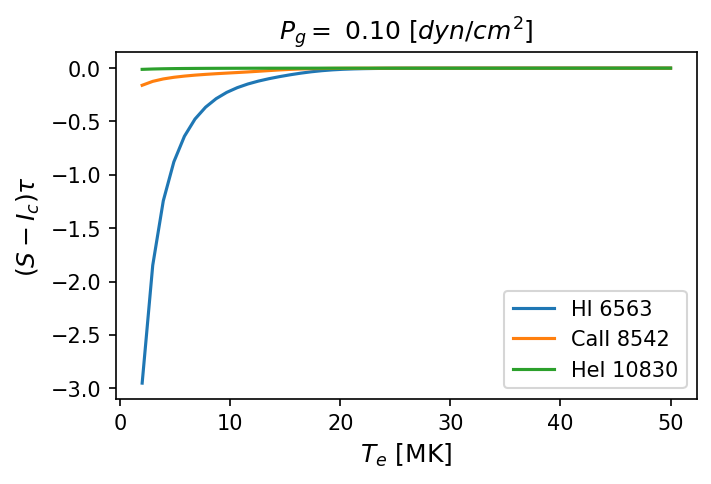

In [46]:
#******************************************************
#  plot population;  neutoral, lower level of Ha & 10830  

j = 10  #  Pg[j]

fig, ax = plt.subplots(1,1, figsize=[5,3], dpi=150)
ax.plot(Te_arr/1000,s6563[j,:],label='HI 6563')
ax.plot(Te_arr/1000,s8542[j,:],label='CaII 8542')
ax.plot(Te_arr/1000,s10830[j,:],label='HeI 10830')
#ax.plot(Te_arr,nH_l[j,:],label='H (n=2)')
#ax.plot(Te_arr,nHe_l[j,:],label='He ('+lower_He+')')

#ax.set_yscale("log")
ax.set_xlabel("$T_e$ [MK]", fontsize=12)
ax.set_ylabel(r"$(S-I_c) \tau$", fontsize=12)
plt.title(f"$P_g=${Pg_arr[j]:5.2F} [$dyn/cm^2$]")
plt.legend()

In [47]:
EW_6563.shape

NameError: name 'EW_6563' is not defined

In [ ]:
Iprof6563 = np.interp(w6563,wl0,Isolar)

fig,ax = plt.subplots(1,1, figsize=(5,3), dpi=150)

ax.plot(w6563,Iprof6563)
ax.plot(w6563,l_arr_H["intens"][:,30,10])

In [ ]:
##  display EW


ddv = dv*1e5/Cst.c_


EW_6563 = np.sum(l_arr_H["intens"][:,:,:]-Ic6563, axis=0)/Ic6563 *ddv*6563.
EW_10830 = np.sum(l_arr_He["intens"][:,:,:]-Ic10830, axis=0)/Ic10830 *ddv*10830.
EW_8542 = np.sum(l_arr_Ca["intens"][:,:,:]-Ic8542, axis=0)/Ic8542 *ddv*8542.

fig, axs = plt.subplots(1,3, figsize=(10,3), dpi=150, sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.2)
cmap = "jet"   #  "inferno"
vmx = 1

ax=axs[0]
sH = ax.pcolormesh(Te,Pg,EW_6563,cmap=cmap,vmin=-vmx,vmax=vmx)
ax.set_title(r"H$_\alpha$: EW")
ax.set_ylabel("$log(P_{g}) \; [dyn/cm^{2}]$")
ax.set_xlabel("$T_{e} \; [K]$")
ax.set_yticks([-2,-1,0,1,2,3,4])
c1 = ax.contour(Te,Pg,EW_6563,levels=[0],colors='black')

ax=axs[1]
sHe = ax.pcolormesh(Te,Pg,EW_10830,cmap=cmap,vmin=-vmx,vmax=vmx)
ax.set_title(r"He10830: EW")
ax.set_xlabel("$T_{e} \; [K]$")
c1 = ax.contour(Te,Pg,EW_10830,levels=[0],colors='black')

ax=axs[2]
sCa = ax.pcolormesh(Te,Pg,EW_8542,cmap=cmap,vmin=-vmx,vmax=vmx)
ax.set_title(r"Ca8542: EW")
ax.set_xlabel("$T_{e} \; [K]$")
c1 = ax.contour(Te,Pg,EW_8542,levels=[0],colors='black')

cax = fig.add_axes([0.93,0.15,0.015,0.6])
fig.colorbar(sH, cax=cax, orientation="vertical")

In [ ]:
fig, ax = plt.subplots(1,1, figsize=[5,3], dpi=150)

j = 10  # Pg

ax.plot(Te_arr/1000,EW_6563[j,:], label='HI 6563A')
ax.plot(Te_arr/1000,EW_8542[j,:], label='CaII 8542A')
ax.plot(Te_arr/1000,EW_10830[j,:], label='HeI 10830A')

ax.set_xlabel("$T_e$ [MK]", fontsize=12)
ax.set_ylabel("EW [A]", fontsize=12)
plt.title(f"$P_g=${Pg_arr[j]:5.2F} [$dyn/cm^2$]")
plt.legend()


In [ ]:
pop_arr_H['SE'].shape

In [ ]:
from spectra_src.Visual import Grotrian
gro = Grotrian.Grotrian(atom, path_dict_He["Grotrian"], )
gro.make_fig(_figsize=(10,6),_dpi=150, _f=50)


In [ ]:
1./1.602176634e-19

In [27]:
# example of pickle save
import pickle

savdir = 'C:\\data\\spectra\\SE_result\\'
f = open(savdir+'HI.pkl',"wb")
pickle.dump(pop_arr_H,f)
pickle.dump(l_arr_H,f)
f.close
f = open(savdir+'HeI.pkl',"wb")
pickle.dump(pop_arr_He,f)
pickle.dump(l_arr_He,f)
f.close
f = open(savdir+'CaII.pkl',"wb")
pickle.dump(pop_arr_Ca,f)
pickle.dump(l_arr_Ca,f)
f.close
print('pop_arr & l_arr saved in '+savdir)

pop_arr & l_arr saved in C:\data\spectra\SE_result\


In [76]:
### level population & intensity container
def popl_con(atom, nNh, nTe, nw):
    
    pop_arr = {
        "LTE" : np.empty((atom.nLevel, nNh, nTe), dtype="float64"),
        "SE"  : np.empty((atom.nLevel, nNh, nTe), dtype="float64"),
    }
    l_arr = {
        "wl0" :    np.empty(atom.nLine, dtype="float64"),
        "Line_mesh_idxs": np.empty([atom.nLine,2], dtype="int64"),
        "wl_1D":   np.empty(nw, dtype="float64"),
        "prof_3D": np.empty((nw, nNh, nTe), dtype="float64"),
        "tau_3D":  np.empty((nw, nNh, nTe), dtype="float64"),
        "src" :    np.empty((atom.nLine, nNh, nTe), dtype="float64"),
    }
    return pop_arr, l_arr

def calc_popl(slab, depth, atom, wMesh, solar_spec, HnSE, pop_arr, l_arr, j, k ):

    SE, Rate = SELib.cal_SE_with_Nh_Te_(atom, slab, wMesh, solar_spec, HnSE)  #  level populations etc.
    l = CloudModel.SE_to_slab_0D_(atom, slab, SE, depth=depth)      # hydrogen lines intensity
    pop_arr["LTE"][:,j,k] = SE.n_LTE[:]
    pop_arr["SE"][:,j,k] = SE.n_SE[:]
    l_arr["prof_3D"][:,j,k] = l.prof_1D
    l_arr["tau_3D"][:,j,k] = l.tau_1D
    l_arr["src"][:,j,k] = l.Src
    n_SE = SE.n_SE

    return pop_arr, l_arr, n_SE

In [195]:
help_(atom_He)

------------------------------------------------------------------------------------------
name                       type                                 value/len/shape
------------------------------------------------------------------------------------------
Atom
|- Z                       int                                  v: 2
|- Mass                    float                                v: 4.0026
|- Abun                    float                                v: 0.09772372209558111
|- nLevel                  int                                  v: 27
|- nLine                   int                                  v: 205
|- nCont                   int                                  v: 26
|- nTran                   int                                  v: 231
|- nRL                     int                                  v: 39
|- Level                   struct array                         s: (27,)
  |-  erg                  float64                              s: (27,)
  |- 

{'folder': 'C:\\home\\python\\spectra\\data\\atom\\He',
 'conf': 'C:\\home\\Python\\spectra\\data\\conf\\He.conf',
 'Level': 'C:\\home\\python\\spectra\\data\\atom\\He\\He.Level',
 'Aji': 'C:\\home\\python\\spectra\\data\\atom\\He\\He.Aji',
 'CEe': 'C:\\home\\python\\spectra\\data\\atom\\He\\He.CE.electron',
 'CIe': 'C:\\home\\python\\spectra\\data\\atom\\He\\He.CI.electron',
 'PI': 'C:\\home\\python\\spectra\\data\\atom\\He\\He.Alpha',
 'RadiativeLine': 'C:\\home\\python\\spectra\\data\\atom\\He\\He.RadiativeLine',
 'Grotrian': 'C:\\home\\python\\spectra\\data\\atom\\He\\He.Grotrian'}

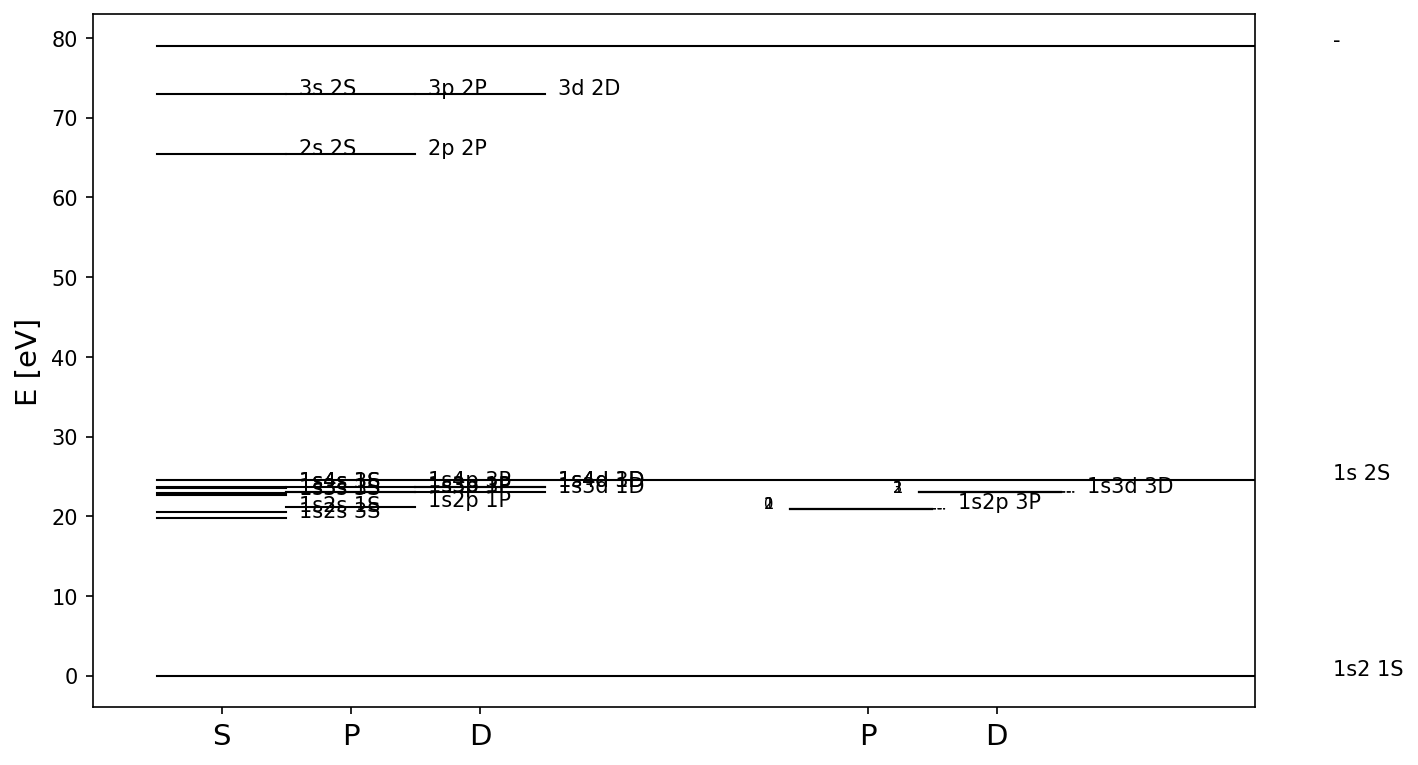

In [197]:
from spectra_src.Visual import Grotrian
scaleFunc     = lambda x: x**(7)
scaleFunc_inv = lambda x : x**(1/7)
gro = Grotrian.Grotrian(atom_He, path_dict_He["Grotrian"])#, _scaleFunc=scaleFunc, _scaleFunc_inv=scaleFunc_inv, )

gro.make_fig(_figsize=(10,6),_dpi=150, _f=50)
path_dict_He